In [4]:
import numerox as nx

nx.data.TRAIN_FILE = 'numerai_training_data.csv'
nx.data.TOURNAMENT_FILE = 'numerai_tournament_data.csv' 
 
data = nx.download('nr.zip')



nr.zip:   0%|                                                                                                             | 0.00/154M [00:00<?, ?B/s]

nr.zip:   0%|                                                                                                  | 1.02k/154M [00:00<5:57:26, 7.17kB/s]

nr.zip:   0%|                                                                                                  | 17.4k/154M [00:00<4:17:01, 9.97kB/s]

nr.zip:   0%|                                                                                                  | 34.8k/154M [00:00<3:06:17, 13.8kB/s]

nr.zip:   0%|                                                                                                  | 68.6k/154M [00:00<2:13:41, 19.2kB/s]

nr.zip:   0%|                                                                                                  | 87.0k/154M [00:00<1:39:38, 25.7kB/s]

nr.zip:   0%|                                                                               

In [254]:
data

region    train, validation, test, live
rows      836711
era       181, [era1, eraX]
x         50, min 0.0000, mean 0.5026, max 1.0000
y         mean 0.499616, fraction missing 0.3321

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

In [10]:
eras = list( data.era[data.region=='train'] ) | select( lambda e: int( e.replace('era','') ) ) | as_list

from keras.utils import to_categorical

eras_y = to_categorical(eras)

In [9]:
%%time

from pipe import *

eras_distinct = set(data.era) | as_list 

era_data = eras    \
        | select( lambda e: np.logical_and( data.region=='train', data.era==e ) ) \
        | select( lambda e: ( data.x[ e ], data.y[3][e] ) ) \
        | where( lambda e: e[0].shape[0] > 0 ) \
        | select( lambda e: train_test_split( e[0], e[1], test_size=0.33  ) ) \
        | as_list()

Wall time: 1min 19s


First build the era-predicting model

In [11]:
import matplotlib.pyplot as plt

def plot(history, val=True, train=True, title='Bernie', metric='loss'):
    if train:
        plt.plot(history.history[metric][2:])
    if val:
        plt.plot(history.history['val_%s' % (metric) ][2:])
        
    plt.title('model %s on %s!' %(metric, title))
    plt.ylabel(metric)
    plt.xlabel('epoch')
    
    labels = []
    if train: 
        labels.append('train')
    if val: 
        labels.append('validation')
        
    plt.legend(labels, loc='upper left')
    plt.show()

In [226]:
%%time

from keras.callbacks import EarlyStopping

Xtrain, Xtest, Ytrain, Ytest = train_test_split( data.x[ data.region=='train' ], eras_y, test_size=0.5 )

model_dense = Sequential([
    Dense(32, input_shape=(50,)),
    Activation('relu'),
    Dropout(0.3),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dropout(0.3),
    Dense(100),
    Dropout(0.3),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dropout(0.3),
    Dense(121),
    Activation('softmax'),
])

model_dense.summary()

model_dense.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_crossentropy','acc'])

callbacks = [EarlyStopping(monitor='val_loss', 
              min_delta=0, 
              patience=100, 
              verbose=0, 
              mode='auto', 
              baseline=None, 
              restore_best_weights=True)]

history = model_dense.fit(Xtrain, 
                    Ytrain, 
                    validation_data=(Xtest,Ytest), 
                    epochs=3000, 
                    callbacks=callbacks,
                    batch_size=10000, 
                    shuffle=True)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_502 (Dense)            (None, 32)                1632      
_________________________________________________________________
activation_502 (Activation)  (None, 32)                0         
_________________________________________________________________
dropout_253 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_503 (Dense)            (None, 100)               3300      
_________________________________________________________________
activation_503 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_504 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_504 (Activation)  (None, 100)               0         
__________

251366/251366 [==============================] - ETA: 0s - loss: 4.7766 - categorical_crossentropy: 4.7766 - acc: 0.01 - ETA: 0s - loss: 4.7769 - categorical_crossentropy: 4.7769 - acc: 0.01 - ETA: 0s - loss: 4.7765 - categorical_crossentropy: 4.7765 - acc: 0.01 - ETA: 0s - loss: 4.7761 - categorical_crossentropy: 4.7761 - acc: 0.01 - ETA: 0s - loss: 4.7764 - categorical_crossentropy: 4.7764 - acc: 0.01 - ETA: 0s - loss: 4.7763 - categorical_crossentropy: 4.7763 - acc: 0.01 - ETA: 0s - loss: 4.7762 - categorical_crossentropy: 4.7762 - acc: 0.01 - ETA: 0s - loss: 4.7761 - categorical_crossentropy: 4.7761 - acc: 0.01 - ETA: 0s - loss: 4.7762 - categorical_crossentropy: 4.7762 - acc: 0.01 - 1s 4us/step - loss: 4.7762 - categorical_crossentropy: 4.7762 - acc: 0.0105 - val_loss: 4.7736 - val_categorical_crossentropy: 4.7736 - val_acc: 0.0102
Epoch 17/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7726 - categorical_crossentropy: 4.7726 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7684 - categorical_crossentropy: 4.7684 - acc: 0.00 - ETA: 0s - loss: 4.7670 - categorical_crossentropy: 4.7670 - acc: 0.01 - ETA: 0s - loss: 4.7673 - categorical_crossentropy: 4.7673 - acc: 0.01 - ETA: 0s - loss: 4.7675 - categorical_crossentropy: 4.7675 - acc: 0.01 - ETA: 0s - loss: 4.7676 - categorical_crossentropy: 4.7676 - acc: 0.01 - ETA: 0s - loss: 4.7679 - categorical_crossentropy: 4.7679 - acc: 0.01 - ETA: 0s - loss: 4.7683 - categorical_crossentropy: 4.7683 - acc: 0.01 - ETA: 0s - loss: 4.7685 - categorical_crossentropy: 4.7685 - acc: 0.01 - ETA: 0s - loss: 4.7686 - categorical_crossentropy: 4.7686 - acc: 0.01 - 1s 4us/step - loss: 4.7686 - categorical_crossentropy: 4.7686 - acc: 0.0108 - val_loss: 4.7669 - val_categorical_crossentropy: 4.7669 - val_acc: 0.0105
Epoch 35/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7684 - categorical_crossentropy: 4.7684 - acc: 0.00 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7590 - categorical_crossentropy: 4.7590 - acc: 0.01 - ETA: 0s - loss: 4.7622 - categorical_crossentropy: 4.7622 - acc: 0.01 - ETA: 0s - loss: 4.7627 - categorical_crossentropy: 4.7627 - acc: 0.01 - ETA: 0s - loss: 4.7625 - categorical_crossentropy: 4.7625 - acc: 0.01 - ETA: 0s - loss: 4.7628 - categorical_crossentropy: 4.7628 - acc: 0.01 - ETA: 0s - loss: 4.7624 - categorical_crossentropy: 4.7624 - acc: 0.01 - ETA: 0s - loss: 4.7626 - categorical_crossentropy: 4.7626 - acc: 0.01 - ETA: 0s - loss: 4.7626 - categorical_crossentropy: 4.7626 - acc: 0.01 - ETA: 0s - loss: 4.7627 - categorical_crossentropy: 4.7627 - acc: 0.01 - 1s 4us/step - loss: 4.7628 - categorical_crossentropy: 4.7628 - acc: 0.0116 - val_loss: 4.7614 - val_categorical_crossentropy: 4.7614 - val_acc: 0.0113
Epoch 53/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7662 - categorical_crossentropy: 4.7662 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7592 - categorical_crossentropy: 4.7592 - acc: 0.01 - ETA: 0s - loss: 4.7580 - categorical_crossentropy: 4.7580 - acc: 0.01 - ETA: 0s - loss: 4.7584 - categorical_crossentropy: 4.7584 - acc: 0.01 - ETA: 0s - loss: 4.7589 - categorical_crossentropy: 4.7589 - acc: 0.01 - ETA: 0s - loss: 4.7584 - categorical_crossentropy: 4.7584 - acc: 0.01 - ETA: 0s - loss: 4.7580 - categorical_crossentropy: 4.7580 - acc: 0.01 - ETA: 0s - loss: 4.7579 - categorical_crossentropy: 4.7579 - acc: 0.01 - ETA: 0s - loss: 4.7579 - categorical_crossentropy: 4.7579 - acc: 0.01 - ETA: 0s - loss: 4.7579 - categorical_crossentropy: 4.7579 - acc: 0.01 - 1s 4us/step - loss: 4.7579 - categorical_crossentropy: 4.7579 - acc: 0.0124 - val_loss: 4.7568 - val_categorical_crossentropy: 4.7568 - val_acc: 0.0118
Epoch 71/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7611 - categorical_crossentropy: 4.7611 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7519 - categorical_crossentropy: 4.7519 - acc: 0.01 - ETA: 0s - loss: 4.7528 - categorical_crossentropy: 4.7528 - acc: 0.01 - ETA: 0s - loss: 4.7523 - categorical_crossentropy: 4.7523 - acc: 0.01 - ETA: 0s - loss: 4.7524 - categorical_crossentropy: 4.7524 - acc: 0.01 - ETA: 0s - loss: 4.7532 - categorical_crossentropy: 4.7532 - acc: 0.01 - ETA: 0s - loss: 4.7536 - categorical_crossentropy: 4.7536 - acc: 0.01 - ETA: 0s - loss: 4.7536 - categorical_crossentropy: 4.7536 - acc: 0.01 - ETA: 0s - loss: 4.7536 - categorical_crossentropy: 4.7536 - acc: 0.01 - ETA: 0s - loss: 4.7536 - categorical_crossentropy: 4.7536 - acc: 0.01 - 1s 4us/step - loss: 4.7537 - categorical_crossentropy: 4.7537 - acc: 0.0124 - val_loss: 4.7506 - val_categorical_crossentropy: 4.7506 - val_acc: 0.0125
Epoch 89/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7536 - categorical_crossentropy: 4.7536 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7503 - categorical_crossentropy: 4.7503 - acc: 0.01 - ETA: 0s - loss: 4.7513 - categorical_crossentropy: 4.7513 - acc: 0.01 - ETA: 0s - loss: 4.7502 - categorical_crossentropy: 4.7502 - acc: 0.01 - ETA: 0s - loss: 4.7506 - categorical_crossentropy: 4.7506 - acc: 0.01 - ETA: 0s - loss: 4.7505 - categorical_crossentropy: 4.7505 - acc: 0.01 - ETA: 0s - loss: 4.7500 - categorical_crossentropy: 4.7500 - acc: 0.01 - ETA: 0s - loss: 4.7499 - categorical_crossentropy: 4.7499 - acc: 0.01 - ETA: 0s - loss: 4.7501 - categorical_crossentropy: 4.7501 - acc: 0.01 - ETA: 0s - loss: 4.7502 - categorical_crossentropy: 4.7502 - acc: 0.01 - 1s 4us/step - loss: 4.7502 - categorical_crossentropy: 4.7502 - acc: 0.0128 - val_loss: 4.7488 - val_categorical_crossentropy: 4.7488 - val_acc: 0.0126
Epoch 107/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7494 - categorical_crossentropy: 4.7494 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7412 - categorical_crossentropy: 4.7412 - acc: 0.01 - ETA: 0s - loss: 4.7458 - categorical_crossentropy: 4.7458 - acc: 0.01 - ETA: 0s - loss: 4.7463 - categorical_crossentropy: 4.7463 - acc: 0.01 - ETA: 0s - loss: 4.7463 - categorical_crossentropy: 4.7463 - acc: 0.01 - ETA: 0s - loss: 4.7462 - categorical_crossentropy: 4.7462 - acc: 0.01 - ETA: 0s - loss: 4.7465 - categorical_crossentropy: 4.7465 - acc: 0.01 - ETA: 0s - loss: 4.7465 - categorical_crossentropy: 4.7465 - acc: 0.01 - ETA: 0s - loss: 4.7468 - categorical_crossentropy: 4.7468 - acc: 0.01 - ETA: 0s - loss: 4.7468 - categorical_crossentropy: 4.7468 - acc: 0.01 - 1s 4us/step - loss: 4.7468 - categorical_crossentropy: 4.7468 - acc: 0.0132 - val_loss: 4.7452 - val_categorical_crossentropy: 4.7452 - val_acc: 0.0129
Epoch 125/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7444 - categorical_crossentropy: 4.7444 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7466 - categorical_crossentropy: 4.7466 - acc: 0.01 - ETA: 0s - loss: 4.7454 - categorical_crossentropy: 4.7454 - acc: 0.01 - ETA: 0s - loss: 4.7446 - categorical_crossentropy: 4.7446 - acc: 0.01 - ETA: 0s - loss: 4.7444 - categorical_crossentropy: 4.7444 - acc: 0.01 - ETA: 0s - loss: 4.7443 - categorical_crossentropy: 4.7443 - acc: 0.01 - ETA: 0s - loss: 4.7448 - categorical_crossentropy: 4.7448 - acc: 0.01 - ETA: 0s - loss: 4.7449 - categorical_crossentropy: 4.7449 - acc: 0.01 - ETA: 0s - loss: 4.7448 - categorical_crossentropy: 4.7448 - acc: 0.01 - ETA: 0s - loss: 4.7448 - categorical_crossentropy: 4.7448 - acc: 0.01 - 1s 4us/step - loss: 4.7448 - categorical_crossentropy: 4.7448 - acc: 0.0133 - val_loss: 4.7446 - val_categorical_crossentropy: 4.7446 - val_acc: 0.0131
Epoch 143/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7423 - categorical_crossentropy: 4.7423 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7394 - categorical_crossentropy: 4.7394 - acc: 0.01 - ETA: 0s - loss: 4.7430 - categorical_crossentropy: 4.7430 - acc: 0.01 - ETA: 0s - loss: 4.7427 - categorical_crossentropy: 4.7427 - acc: 0.01 - ETA: 0s - loss: 4.7422 - categorical_crossentropy: 4.7422 - acc: 0.01 - ETA: 0s - loss: 4.7423 - categorical_crossentropy: 4.7423 - acc: 0.01 - ETA: 0s - loss: 4.7421 - categorical_crossentropy: 4.7421 - acc: 0.01 - ETA: 0s - loss: 4.7417 - categorical_crossentropy: 4.7417 - acc: 0.01 - ETA: 0s - loss: 4.7416 - categorical_crossentropy: 4.7416 - acc: 0.01 - ETA: 0s - loss: 4.7421 - categorical_crossentropy: 4.7421 - acc: 0.01 - 1s 4us/step - loss: 4.7421 - categorical_crossentropy: 4.7421 - acc: 0.0137 - val_loss: 4.7415 - val_categorical_crossentropy: 4.7415 - val_acc: 0.0129
Epoch 161/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7462 - categorical_crossentropy: 4.7462 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7408 - categorical_crossentropy: 4.7408 - acc: 0.01 - ETA: 0s - loss: 4.7403 - categorical_crossentropy: 4.7403 - acc: 0.01 - ETA: 0s - loss: 4.7405 - categorical_crossentropy: 4.7405 - acc: 0.01 - ETA: 0s - loss: 4.7398 - categorical_crossentropy: 4.7398 - acc: 0.01 - ETA: 0s - loss: 4.7401 - categorical_crossentropy: 4.7401 - acc: 0.01 - ETA: 0s - loss: 4.7399 - categorical_crossentropy: 4.7399 - acc: 0.01 - ETA: 0s - loss: 4.7404 - categorical_crossentropy: 4.7404 - acc: 0.01 - ETA: 0s - loss: 4.7404 - categorical_crossentropy: 4.7404 - acc: 0.01 - ETA: 0s - loss: 4.7402 - categorical_crossentropy: 4.7402 - acc: 0.01 - 1s 4us/step - loss: 4.7401 - categorical_crossentropy: 4.7401 - acc: 0.0135 - val_loss: 4.7412 - val_categorical_crossentropy: 4.7412 - val_acc: 0.0135
Epoch 179/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7403 - categorical_crossentropy: 4.7403 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.01 - ETA: 0s - loss: 4.7381 - categorical_crossentropy: 4.7381 - acc: 0.01 - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - ETA: 0s - loss: 4.7390 - categorical_crossentropy: 4.7390 - acc: 0.01 - ETA: 0s - loss: 4.7386 - categorical_crossentropy: 4.7386 - acc: 0.01 - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - ETA: 0s - loss: 4.7386 - categorical_crossentropy: 4.7386 - acc: 0.01 - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - 1s 4us/step - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.0141 - val_loss: 4.7399 - val_categorical_crossentropy: 4.7399 - val_acc: 0.0138
Epoch 197/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7335 - categorical_crossentropy: 4.7335 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7358 - categorical_crossentropy: 4.7358 - acc: 0.01 - ETA: 0s - loss: 4.7387 - categorical_crossentropy: 4.7387 - acc: 0.01 - ETA: 0s - loss: 4.7363 - categorical_crossentropy: 4.7363 - acc: 0.01 - ETA: 0s - loss: 4.7373 - categorical_crossentropy: 4.7373 - acc: 0.01 - ETA: 0s - loss: 4.7370 - categorical_crossentropy: 4.7370 - acc: 0.01 - ETA: 0s - loss: 4.7369 - categorical_crossentropy: 4.7369 - acc: 0.01 - ETA: 0s - loss: 4.7365 - categorical_crossentropy: 4.7365 - acc: 0.01 - ETA: 0s - loss: 4.7364 - categorical_crossentropy: 4.7364 - acc: 0.01 - ETA: 0s - loss: 4.7369 - categorical_crossentropy: 4.7369 - acc: 0.01 - 1s 4us/step - loss: 4.7368 - categorical_crossentropy: 4.7368 - acc: 0.0143 - val_loss: 4.7408 - val_categorical_crossentropy: 4.7408 - val_acc: 0.0135
Epoch 215/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7329 - categorical_crossentropy: 4.7329 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7348 - categorical_crossentropy: 4.7348 - acc: 0.01 - ETA: 0s - loss: 4.7352 - categorical_crossentropy: 4.7352 - acc: 0.01 - ETA: 0s - loss: 4.7353 - categorical_crossentropy: 4.7353 - acc: 0.01 - ETA: 0s - loss: 4.7345 - categorical_crossentropy: 4.7345 - acc: 0.01 - ETA: 0s - loss: 4.7351 - categorical_crossentropy: 4.7351 - acc: 0.01 - ETA: 0s - loss: 4.7356 - categorical_crossentropy: 4.7356 - acc: 0.01 - ETA: 0s - loss: 4.7352 - categorical_crossentropy: 4.7352 - acc: 0.01 - ETA: 0s - loss: 4.7355 - categorical_crossentropy: 4.7355 - acc: 0.01 - ETA: 0s - loss: 4.7354 - categorical_crossentropy: 4.7354 - acc: 0.01 - 1s 4us/step - loss: 4.7353 - categorical_crossentropy: 4.7353 - acc: 0.0142 - val_loss: 4.7391 - val_categorical_crossentropy: 4.7391 - val_acc: 0.0139
Epoch 233/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7369 - categorical_crossentropy: 4.7369 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7325 - categorical_crossentropy: 4.7325 - acc: 0.01 - ETA: 0s - loss: 4.7327 - categorical_crossentropy: 4.7327 - acc: 0.01 - ETA: 0s - loss: 4.7340 - categorical_crossentropy: 4.7340 - acc: 0.01 - ETA: 0s - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.01 - ETA: 0s - loss: 4.7331 - categorical_crossentropy: 4.7331 - acc: 0.01 - ETA: 0s - loss: 4.7335 - categorical_crossentropy: 4.7335 - acc: 0.01 - ETA: 0s - loss: 4.7336 - categorical_crossentropy: 4.7336 - acc: 0.01 - ETA: 0s - loss: 4.7333 - categorical_crossentropy: 4.7333 - acc: 0.01 - ETA: 0s - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.01 - 1s 4us/step - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.0146 - val_loss: 4.7348 - val_categorical_crossentropy: 4.7348 - val_acc: 0.0138
Epoch 251/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7316 - categorical_crossentropy: 4.7316 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7298 - categorical_crossentropy: 4.7298 - acc: 0.01 - ETA: 0s - loss: 4.7330 - categorical_crossentropy: 4.7330 - acc: 0.01 - ETA: 0s - loss: 4.7333 - categorical_crossentropy: 4.7333 - acc: 0.01 - ETA: 0s - loss: 4.7335 - categorical_crossentropy: 4.7335 - acc: 0.01 - ETA: 0s - loss: 4.7328 - categorical_crossentropy: 4.7328 - acc: 0.01 - ETA: 0s - loss: 4.7326 - categorical_crossentropy: 4.7326 - acc: 0.01 - ETA: 0s - loss: 4.7329 - categorical_crossentropy: 4.7329 - acc: 0.01 - ETA: 0s - loss: 4.7325 - categorical_crossentropy: 4.7325 - acc: 0.01 - ETA: 0s - loss: 4.7321 - categorical_crossentropy: 4.7321 - acc: 0.01 - 1s 4us/step - loss: 4.7320 - categorical_crossentropy: 4.7320 - acc: 0.0147 - val_loss: 4.7329 - val_categorical_crossentropy: 4.7329 - val_acc: 0.0142
Epoch 269/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7271 - categorical_crossentropy: 4.7271 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7309 - categorical_crossentropy: 4.7309 - acc: 0.01 - ETA: 0s - loss: 4.7285 - categorical_crossentropy: 4.7285 - acc: 0.01 - ETA: 0s - loss: 4.7291 - categorical_crossentropy: 4.7291 - acc: 0.01 - ETA: 0s - loss: 4.7287 - categorical_crossentropy: 4.7287 - acc: 0.01 - ETA: 0s - loss: 4.7289 - categorical_crossentropy: 4.7289 - acc: 0.01 - ETA: 0s - loss: 4.7292 - categorical_crossentropy: 4.7292 - acc: 0.01 - ETA: 0s - loss: 4.7289 - categorical_crossentropy: 4.7289 - acc: 0.01 - ETA: 0s - loss: 4.7291 - categorical_crossentropy: 4.7291 - acc: 0.01 - ETA: 0s - loss: 4.7295 - categorical_crossentropy: 4.7295 - acc: 0.01 - 1s 4us/step - loss: 4.7295 - categorical_crossentropy: 4.7295 - acc: 0.0148 - val_loss: 4.7366 - val_categorical_crossentropy: 4.7366 - val_acc: 0.0138
Epoch 287/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7343 - categorical_crossentropy: 4.7343 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7229 - categorical_crossentropy: 4.7229 - acc: 0.01 - ETA: 0s - loss: 4.7269 - categorical_crossentropy: 4.7269 - acc: 0.01 - ETA: 0s - loss: 4.7293 - categorical_crossentropy: 4.7293 - acc: 0.01 - ETA: 0s - loss: 4.7295 - categorical_crossentropy: 4.7295 - acc: 0.01 - ETA: 0s - loss: 4.7293 - categorical_crossentropy: 4.7293 - acc: 0.01 - ETA: 0s - loss: 4.7285 - categorical_crossentropy: 4.7285 - acc: 0.01 - ETA: 0s - loss: 4.7283 - categorical_crossentropy: 4.7283 - acc: 0.01 - ETA: 0s - loss: 4.7286 - categorical_crossentropy: 4.7286 - acc: 0.01 - ETA: 0s - loss: 4.7287 - categorical_crossentropy: 4.7287 - acc: 0.01 - 1s 4us/step - loss: 4.7287 - categorical_crossentropy: 4.7287 - acc: 0.0152 - val_loss: 4.7382 - val_categorical_crossentropy: 4.7382 - val_acc: 0.0137
Epoch 305/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7315 - categorical_crossentropy: 4.7315 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7211 - categorical_crossentropy: 4.7211 - acc: 0.01 - ETA: 0s - loss: 4.7248 - categorical_crossentropy: 4.7248 - acc: 0.01 - ETA: 0s - loss: 4.7271 - categorical_crossentropy: 4.7271 - acc: 0.01 - ETA: 0s - loss: 4.7276 - categorical_crossentropy: 4.7276 - acc: 0.01 - ETA: 0s - loss: 4.7270 - categorical_crossentropy: 4.7270 - acc: 0.01 - ETA: 0s - loss: 4.7274 - categorical_crossentropy: 4.7274 - acc: 0.01 - ETA: 0s - loss: 4.7275 - categorical_crossentropy: 4.7275 - acc: 0.01 - ETA: 0s - loss: 4.7276 - categorical_crossentropy: 4.7276 - acc: 0.01 - ETA: 0s - loss: 4.7274 - categorical_crossentropy: 4.7274 - acc: 0.01 - 1s 4us/step - loss: 4.7273 - categorical_crossentropy: 4.7273 - acc: 0.0150 - val_loss: 4.7356 - val_categorical_crossentropy: 4.7356 - val_acc: 0.0137
Epoch 323/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7266 - categorical_crossentropy: 4.7266 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7176 - categorical_crossentropy: 4.7176 - acc: 0.01 - ETA: 0s - loss: 4.7221 - categorical_crossentropy: 4.7221 - acc: 0.01 - ETA: 0s - loss: 4.7234 - categorical_crossentropy: 4.7234 - acc: 0.01 - ETA: 0s - loss: 4.7231 - categorical_crossentropy: 4.7231 - acc: 0.01 - ETA: 0s - loss: 4.7235 - categorical_crossentropy: 4.7235 - acc: 0.01 - ETA: 0s - loss: 4.7242 - categorical_crossentropy: 4.7242 - acc: 0.01 - ETA: 0s - loss: 4.7250 - categorical_crossentropy: 4.7250 - acc: 0.01 - ETA: 0s - loss: 4.7250 - categorical_crossentropy: 4.7250 - acc: 0.01 - ETA: 0s - loss: 4.7252 - categorical_crossentropy: 4.7252 - acc: 0.01 - 1s 4us/step - loss: 4.7251 - categorical_crossentropy: 4.7251 - acc: 0.0150 - val_loss: 4.7292 - val_categorical_crossentropy: 4.7292 - val_acc: 0.0143
Epoch 341/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7184 - categorical_crossentropy: 4.7184 - acc: 0.01 - ETA: 0s - loss:

Epoch 349/3000
251366/251366 [==============================] - ETA: 1s - loss: 4.7257 - categorical_crossentropy: 4.7257 - acc: 0.01 - ETA: 0s - loss: 4.7235 - categorical_crossentropy: 4.7235 - acc: 0.01 - ETA: 0s - loss: 4.7232 - categorical_crossentropy: 4.7232 - acc: 0.01 - ETA: 0s - loss: 4.7237 - categorical_crossentropy: 4.7237 - acc: 0.01 - ETA: 0s - loss: 4.7241 - categorical_crossentropy: 4.7241 - acc: 0.01 - ETA: 0s - loss: 4.7244 - categorical_crossentropy: 4.7244 - acc: 0.01 - ETA: 0s - loss: 4.7241 - categorical_crossentropy: 4.7241 - acc: 0.01 - ETA: 0s - loss: 4.7240 - categorical_crossentropy: 4.7240 - acc: 0.01 - ETA: 0s - loss: 4.7241 - categorical_crossentropy: 4.7241 - acc: 0.01 - ETA: 0s - loss: 4.7241 - categorical_crossentropy: 4.7241 - acc: 0.01 - 1s 4us/step - loss: 4.7242 - categorical_crossentropy: 4.7242 - acc: 0.0150 - val_loss: 4.7345 - val_categorical_crossentropy: 4.7345 - val_acc: 0.0142
Epoch 350/3000
251366/251366 [==============================] - 

251366/251366 [==============================] - ETA: 0s - loss: 4.7206 - categorical_crossentropy: 4.7206 - acc: 0.01 - ETA: 0s - loss: 4.7208 - categorical_crossentropy: 4.7208 - acc: 0.01 - ETA: 0s - loss: 4.7220 - categorical_crossentropy: 4.7220 - acc: 0.01 - ETA: 0s - loss: 4.7221 - categorical_crossentropy: 4.7221 - acc: 0.01 - ETA: 0s - loss: 4.7230 - categorical_crossentropy: 4.7230 - acc: 0.01 - ETA: 0s - loss: 4.7228 - categorical_crossentropy: 4.7228 - acc: 0.01 - ETA: 0s - loss: 4.7221 - categorical_crossentropy: 4.7221 - acc: 0.01 - ETA: 0s - loss: 4.7226 - categorical_crossentropy: 4.7226 - acc: 0.01 - ETA: 0s - loss: 4.7224 - categorical_crossentropy: 4.7224 - acc: 0.01 - 1s 4us/step - loss: 4.7224 - categorical_crossentropy: 4.7224 - acc: 0.0152 - val_loss: 4.7290 - val_categorical_crossentropy: 4.7290 - val_acc: 0.0146
Epoch 368/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7192 - categorical_crossentropy: 4.7192 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7206 - categorical_crossentropy: 4.7206 - acc: 0.01 - ETA: 0s - loss: 4.7181 - categorical_crossentropy: 4.7181 - acc: 0.01 - ETA: 0s - loss: 4.7202 - categorical_crossentropy: 4.7202 - acc: 0.01 - ETA: 0s - loss: 4.7204 - categorical_crossentropy: 4.7204 - acc: 0.01 - ETA: 0s - loss: 4.7203 - categorical_crossentropy: 4.7203 - acc: 0.01 - ETA: 0s - loss: 4.7201 - categorical_crossentropy: 4.7201 - acc: 0.01 - ETA: 0s - loss: 4.7206 - categorical_crossentropy: 4.7206 - acc: 0.01 - ETA: 0s - loss: 4.7205 - categorical_crossentropy: 4.7205 - acc: 0.01 - ETA: 0s - loss: 4.7207 - categorical_crossentropy: 4.7207 - acc: 0.01 - 1s 4us/step - loss: 4.7206 - categorical_crossentropy: 4.7206 - acc: 0.0157 - val_loss: 4.7276 - val_categorical_crossentropy: 4.7276 - val_acc: 0.0145
Epoch 386/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7246 - categorical_crossentropy: 4.7246 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7232 - categorical_crossentropy: 4.7232 - acc: 0.01 - ETA: 0s - loss: 4.7209 - categorical_crossentropy: 4.7209 - acc: 0.01 - ETA: 0s - loss: 4.7189 - categorical_crossentropy: 4.7189 - acc: 0.01 - ETA: 0s - loss: 4.7193 - categorical_crossentropy: 4.7193 - acc: 0.01 - ETA: 0s - loss: 4.7188 - categorical_crossentropy: 4.7188 - acc: 0.01 - ETA: 0s - loss: 4.7183 - categorical_crossentropy: 4.7183 - acc: 0.01 - ETA: 0s - loss: 4.7188 - categorical_crossentropy: 4.7188 - acc: 0.01 - ETA: 0s - loss: 4.7184 - categorical_crossentropy: 4.7184 - acc: 0.01 - ETA: 0s - loss: 4.7188 - categorical_crossentropy: 4.7188 - acc: 0.01 - 1s 4us/step - loss: 4.7188 - categorical_crossentropy: 4.7188 - acc: 0.0156 - val_loss: 4.7322 - val_categorical_crossentropy: 4.7322 - val_acc: 0.0147
Epoch 404/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7151 - categorical_crossentropy: 4.7151 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7156 - categorical_crossentropy: 4.7156 - acc: 0.01 - ETA: 0s - loss: 4.7172 - categorical_crossentropy: 4.7172 - acc: 0.01 - ETA: 0s - loss: 4.7171 - categorical_crossentropy: 4.7171 - acc: 0.01 - ETA: 0s - loss: 4.7162 - categorical_crossentropy: 4.7162 - acc: 0.01 - ETA: 0s - loss: 4.7155 - categorical_crossentropy: 4.7155 - acc: 0.01 - ETA: 0s - loss: 4.7154 - categorical_crossentropy: 4.7154 - acc: 0.01 - ETA: 0s - loss: 4.7151 - categorical_crossentropy: 4.7151 - acc: 0.01 - ETA: 0s - loss: 4.7153 - categorical_crossentropy: 4.7153 - acc: 0.01 - ETA: 0s - loss: 4.7154 - categorical_crossentropy: 4.7154 - acc: 0.01 - 1s 4us/step - loss: 4.7153 - categorical_crossentropy: 4.7153 - acc: 0.0159 - val_loss: 4.7317 - val_categorical_crossentropy: 4.7317 - val_acc: 0.0147
Epoch 422/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7131 - categorical_crossentropy: 4.7131 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7151 - categorical_crossentropy: 4.7151 - acc: 0.01 - ETA: 0s - loss: 4.7130 - categorical_crossentropy: 4.7130 - acc: 0.01 - ETA: 0s - loss: 4.7127 - categorical_crossentropy: 4.7127 - acc: 0.01 - ETA: 0s - loss: 4.7125 - categorical_crossentropy: 4.7125 - acc: 0.01 - ETA: 0s - loss: 4.7130 - categorical_crossentropy: 4.7130 - acc: 0.01 - ETA: 0s - loss: 4.7127 - categorical_crossentropy: 4.7127 - acc: 0.01 - ETA: 0s - loss: 4.7135 - categorical_crossentropy: 4.7135 - acc: 0.01 - ETA: 0s - loss: 4.7137 - categorical_crossentropy: 4.7137 - acc: 0.01 - ETA: 0s - loss: 4.7135 - categorical_crossentropy: 4.7135 - acc: 0.01 - 1s 4us/step - loss: 4.7135 - categorical_crossentropy: 4.7135 - acc: 0.0155 - val_loss: 4.7229 - val_categorical_crossentropy: 4.7229 - val_acc: 0.0155
Epoch 440/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7176 - categorical_crossentropy: 4.7176 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7050 - categorical_crossentropy: 4.7050 - acc: 0.01 - ETA: 0s - loss: 4.7093 - categorical_crossentropy: 4.7093 - acc: 0.01 - ETA: 0s - loss: 4.7110 - categorical_crossentropy: 4.7110 - acc: 0.01 - ETA: 0s - loss: 4.7110 - categorical_crossentropy: 4.7110 - acc: 0.01 - ETA: 0s - loss: 4.7111 - categorical_crossentropy: 4.7111 - acc: 0.01 - ETA: 0s - loss: 4.7113 - categorical_crossentropy: 4.7113 - acc: 0.01 - ETA: 0s - loss: 4.7112 - categorical_crossentropy: 4.7112 - acc: 0.01 - ETA: 0s - loss: 4.7108 - categorical_crossentropy: 4.7108 - acc: 0.01 - ETA: 0s - loss: 4.7105 - categorical_crossentropy: 4.7105 - acc: 0.01 - 1s 4us/step - loss: 4.7106 - categorical_crossentropy: 4.7106 - acc: 0.0154 - val_loss: 4.7261 - val_categorical_crossentropy: 4.7261 - val_acc: 0.0147
Epoch 458/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7128 - categorical_crossentropy: 4.7128 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7117 - categorical_crossentropy: 4.7117 - acc: 0.01 - ETA: 0s - loss: 4.7120 - categorical_crossentropy: 4.7120 - acc: 0.01 - ETA: 0s - loss: 4.7115 - categorical_crossentropy: 4.7115 - acc: 0.01 - ETA: 0s - loss: 4.7103 - categorical_crossentropy: 4.7103 - acc: 0.01 - ETA: 0s - loss: 4.7099 - categorical_crossentropy: 4.7099 - acc: 0.01 - ETA: 0s - loss: 4.7098 - categorical_crossentropy: 4.7098 - acc: 0.01 - ETA: 0s - loss: 4.7094 - categorical_crossentropy: 4.7094 - acc: 0.01 - ETA: 0s - loss: 4.7094 - categorical_crossentropy: 4.7094 - acc: 0.01 - ETA: 0s - loss: 4.7089 - categorical_crossentropy: 4.7089 - acc: 0.01 - 1s 4us/step - loss: 4.7088 - categorical_crossentropy: 4.7088 - acc: 0.0161 - val_loss: 4.7174 - val_categorical_crossentropy: 4.7174 - val_acc: 0.0154
Epoch 476/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7037 - categorical_crossentropy: 4.7037 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7129 - categorical_crossentropy: 4.7129 - acc: 0.01 - ETA: 0s - loss: 4.7085 - categorical_crossentropy: 4.7085 - acc: 0.01 - ETA: 0s - loss: 4.7078 - categorical_crossentropy: 4.7078 - acc: 0.01 - ETA: 0s - loss: 4.7073 - categorical_crossentropy: 4.7073 - acc: 0.01 - ETA: 0s - loss: 4.7076 - categorical_crossentropy: 4.7076 - acc: 0.01 - ETA: 0s - loss: 4.7070 - categorical_crossentropy: 4.7070 - acc: 0.01 - ETA: 0s - loss: 4.7070 - categorical_crossentropy: 4.7070 - acc: 0.01 - ETA: 0s - loss: 4.7069 - categorical_crossentropy: 4.7069 - acc: 0.01 - ETA: 0s - loss: 4.7074 - categorical_crossentropy: 4.7074 - acc: 0.01 - 1s 4us/step - loss: 4.7075 - categorical_crossentropy: 4.7075 - acc: 0.0166 - val_loss: 4.7207 - val_categorical_crossentropy: 4.7207 - val_acc: 0.0153
Epoch 494/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7056 - categorical_crossentropy: 4.7056 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7096 - categorical_crossentropy: 4.7096 - acc: 0.01 - ETA: 0s - loss: 4.7073 - categorical_crossentropy: 4.7073 - acc: 0.01 - ETA: 0s - loss: 4.7064 - categorical_crossentropy: 4.7064 - acc: 0.01 - ETA: 0s - loss: 4.7052 - categorical_crossentropy: 4.7052 - acc: 0.01 - ETA: 0s - loss: 4.7057 - categorical_crossentropy: 4.7057 - acc: 0.01 - ETA: 0s - loss: 4.7049 - categorical_crossentropy: 4.7049 - acc: 0.01 - ETA: 0s - loss: 4.7049 - categorical_crossentropy: 4.7049 - acc: 0.01 - ETA: 0s - loss: 4.7046 - categorical_crossentropy: 4.7046 - acc: 0.01 - ETA: 0s - loss: 4.7045 - categorical_crossentropy: 4.7045 - acc: 0.01 - 1s 4us/step - loss: 4.7045 - categorical_crossentropy: 4.7045 - acc: 0.0163 - val_loss: 4.7302 - val_categorical_crossentropy: 4.7302 - val_acc: 0.0146
Epoch 512/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7013 - categorical_crossentropy: 4.7013 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7032 - categorical_crossentropy: 4.7032 - acc: 0.01 - ETA: 0s - loss: 4.7010 - categorical_crossentropy: 4.7010 - acc: 0.01 - ETA: 0s - loss: 4.7047 - categorical_crossentropy: 4.7047 - acc: 0.01 - ETA: 0s - loss: 4.7042 - categorical_crossentropy: 4.7042 - acc: 0.01 - ETA: 0s - loss: 4.7036 - categorical_crossentropy: 4.7036 - acc: 0.01 - ETA: 0s - loss: 4.7037 - categorical_crossentropy: 4.7037 - acc: 0.01 - ETA: 0s - loss: 4.7038 - categorical_crossentropy: 4.7038 - acc: 0.01 - ETA: 0s - loss: 4.7034 - categorical_crossentropy: 4.7034 - acc: 0.01 - ETA: 0s - loss: 4.7035 - categorical_crossentropy: 4.7035 - acc: 0.01 - 1s 4us/step - loss: 4.7034 - categorical_crossentropy: 4.7034 - acc: 0.0168 - val_loss: 4.7182 - val_categorical_crossentropy: 4.7182 - val_acc: 0.0150
Epoch 530/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7009 - categorical_crossentropy: 4.7009 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6976 - categorical_crossentropy: 4.6976 - acc: 0.01 - ETA: 0s - loss: 4.6990 - categorical_crossentropy: 4.6990 - acc: 0.01 - ETA: 0s - loss: 4.6984 - categorical_crossentropy: 4.6984 - acc: 0.01 - ETA: 0s - loss: 4.6989 - categorical_crossentropy: 4.6989 - acc: 0.01 - ETA: 0s - loss: 4.6992 - categorical_crossentropy: 4.6992 - acc: 0.01 - ETA: 0s - loss: 4.6986 - categorical_crossentropy: 4.6986 - acc: 0.01 - ETA: 0s - loss: 4.6997 - categorical_crossentropy: 4.6997 - acc: 0.01 - ETA: 0s - loss: 4.6998 - categorical_crossentropy: 4.6998 - acc: 0.01 - ETA: 0s - loss: 4.6997 - categorical_crossentropy: 4.6997 - acc: 0.01 - 1s 4us/step - loss: 4.6999 - categorical_crossentropy: 4.6999 - acc: 0.0167 - val_loss: 4.7159 - val_categorical_crossentropy: 4.7159 - val_acc: 0.0155
Epoch 548/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7074 - categorical_crossentropy: 4.7074 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6981 - categorical_crossentropy: 4.6981 - acc: 0.01 - ETA: 0s - loss: 4.6975 - categorical_crossentropy: 4.6975 - acc: 0.01 - ETA: 0s - loss: 4.6984 - categorical_crossentropy: 4.6984 - acc: 0.01 - ETA: 0s - loss: 4.6988 - categorical_crossentropy: 4.6988 - acc: 0.01 - ETA: 0s - loss: 4.6991 - categorical_crossentropy: 4.6991 - acc: 0.01 - ETA: 0s - loss: 4.6990 - categorical_crossentropy: 4.6990 - acc: 0.01 - ETA: 0s - loss: 4.6987 - categorical_crossentropy: 4.6987 - acc: 0.01 - ETA: 0s - loss: 4.6985 - categorical_crossentropy: 4.6985 - acc: 0.01 - ETA: 0s - loss: 4.6985 - categorical_crossentropy: 4.6985 - acc: 0.01 - 1s 4us/step - loss: 4.6985 - categorical_crossentropy: 4.6985 - acc: 0.0167 - val_loss: 4.7147 - val_categorical_crossentropy: 4.7147 - val_acc: 0.0158
Epoch 566/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.7025 - categorical_crossentropy: 4.7025 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7020 - categorical_crossentropy: 4.7020 - acc: 0.01 - ETA: 0s - loss: 4.6969 - categorical_crossentropy: 4.6969 - acc: 0.01 - ETA: 0s - loss: 4.6963 - categorical_crossentropy: 4.6963 - acc: 0.01 - ETA: 0s - loss: 4.6966 - categorical_crossentropy: 4.6966 - acc: 0.01 - ETA: 0s - loss: 4.6969 - categorical_crossentropy: 4.6969 - acc: 0.01 - ETA: 0s - loss: 4.6968 - categorical_crossentropy: 4.6968 - acc: 0.01 - ETA: 0s - loss: 4.6965 - categorical_crossentropy: 4.6965 - acc: 0.01 - ETA: 0s - loss: 4.6958 - categorical_crossentropy: 4.6958 - acc: 0.01 - ETA: 0s - loss: 4.6958 - categorical_crossentropy: 4.6958 - acc: 0.01 - 1s 4us/step - loss: 4.6959 - categorical_crossentropy: 4.6959 - acc: 0.0169 - val_loss: 4.7117 - val_categorical_crossentropy: 4.7117 - val_acc: 0.0161
Epoch 584/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6983 - categorical_crossentropy: 4.6983 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6938 - categorical_crossentropy: 4.6938 - acc: 0.01 - ETA: 0s - loss: 4.6945 - categorical_crossentropy: 4.6945 - acc: 0.01 - ETA: 0s - loss: 4.6928 - categorical_crossentropy: 4.6928 - acc: 0.01 - ETA: 0s - loss: 4.6914 - categorical_crossentropy: 4.6914 - acc: 0.01 - ETA: 0s - loss: 4.6916 - categorical_crossentropy: 4.6916 - acc: 0.01 - ETA: 0s - loss: 4.6924 - categorical_crossentropy: 4.6924 - acc: 0.01 - ETA: 0s - loss: 4.6927 - categorical_crossentropy: 4.6927 - acc: 0.01 - ETA: 0s - loss: 4.6929 - categorical_crossentropy: 4.6929 - acc: 0.01 - ETA: 0s - loss: 4.6932 - categorical_crossentropy: 4.6932 - acc: 0.01 - 1s 4us/step - loss: 4.6931 - categorical_crossentropy: 4.6931 - acc: 0.0172 - val_loss: 4.7128 - val_categorical_crossentropy: 4.7128 - val_acc: 0.0157
Epoch 602/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6865 - categorical_crossentropy: 4.6865 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.7000 - categorical_crossentropy: 4.7000 - acc: 0.01 - ETA: 0s - loss: 4.6938 - categorical_crossentropy: 4.6938 - acc: 0.01 - ETA: 0s - loss: 4.6929 - categorical_crossentropy: 4.6929 - acc: 0.01 - ETA: 0s - loss: 4.6929 - categorical_crossentropy: 4.6929 - acc: 0.01 - ETA: 0s - loss: 4.6918 - categorical_crossentropy: 4.6918 - acc: 0.01 - ETA: 0s - loss: 4.6910 - categorical_crossentropy: 4.6910 - acc: 0.01 - ETA: 0s - loss: 4.6916 - categorical_crossentropy: 4.6916 - acc: 0.01 - ETA: 0s - loss: 4.6915 - categorical_crossentropy: 4.6915 - acc: 0.01 - ETA: 0s - loss: 4.6915 - categorical_crossentropy: 4.6915 - acc: 0.01 - 1s 4us/step - loss: 4.6915 - categorical_crossentropy: 4.6915 - acc: 0.0168 - val_loss: 4.7063 - val_categorical_crossentropy: 4.7063 - val_acc: 0.0162
Epoch 620/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6862 - categorical_crossentropy: 4.6862 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6826 - categorical_crossentropy: 4.6826 - acc: 0.01 - ETA: 0s - loss: 4.6865 - categorical_crossentropy: 4.6865 - acc: 0.01 - ETA: 0s - loss: 4.6892 - categorical_crossentropy: 4.6892 - acc: 0.01 - ETA: 0s - loss: 4.6893 - categorical_crossentropy: 4.6893 - acc: 0.01 - ETA: 0s - loss: 4.6886 - categorical_crossentropy: 4.6886 - acc: 0.01 - ETA: 0s - loss: 4.6895 - categorical_crossentropy: 4.6895 - acc: 0.01 - ETA: 0s - loss: 4.6891 - categorical_crossentropy: 4.6891 - acc: 0.01 - ETA: 0s - loss: 4.6888 - categorical_crossentropy: 4.6888 - acc: 0.01 - ETA: 0s - loss: 4.6890 - categorical_crossentropy: 4.6890 - acc: 0.01 - 1s 4us/step - loss: 4.6889 - categorical_crossentropy: 4.6889 - acc: 0.0177 - val_loss: 4.7074 - val_categorical_crossentropy: 4.7074 - val_acc: 0.0160
Epoch 638/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6866 - categorical_crossentropy: 4.6866 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6857 - categorical_crossentropy: 4.6857 - acc: 0.01 - ETA: 0s - loss: 4.6858 - categorical_crossentropy: 4.6858 - acc: 0.01 - ETA: 0s - loss: 4.6868 - categorical_crossentropy: 4.6868 - acc: 0.01 - ETA: 0s - loss: 4.6868 - categorical_crossentropy: 4.6868 - acc: 0.01 - ETA: 0s - loss: 4.6880 - categorical_crossentropy: 4.6880 - acc: 0.01 - ETA: 0s - loss: 4.6877 - categorical_crossentropy: 4.6877 - acc: 0.01 - ETA: 0s - loss: 4.6875 - categorical_crossentropy: 4.6875 - acc: 0.01 - ETA: 0s - loss: 4.6874 - categorical_crossentropy: 4.6874 - acc: 0.01 - ETA: 0s - loss: 4.6874 - categorical_crossentropy: 4.6874 - acc: 0.01 - 1s 4us/step - loss: 4.6874 - categorical_crossentropy: 4.6874 - acc: 0.0175 - val_loss: 4.7080 - val_categorical_crossentropy: 4.7080 - val_acc: 0.0161
Epoch 656/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6850 - categorical_crossentropy: 4.6850 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6883 - categorical_crossentropy: 4.6883 - acc: 0.01 - ETA: 0s - loss: 4.6868 - categorical_crossentropy: 4.6868 - acc: 0.01 - ETA: 0s - loss: 4.6850 - categorical_crossentropy: 4.6850 - acc: 0.01 - ETA: 0s - loss: 4.6847 - categorical_crossentropy: 4.6847 - acc: 0.01 - ETA: 0s - loss: 4.6855 - categorical_crossentropy: 4.6855 - acc: 0.01 - ETA: 0s - loss: 4.6851 - categorical_crossentropy: 4.6851 - acc: 0.01 - ETA: 0s - loss: 4.6855 - categorical_crossentropy: 4.6855 - acc: 0.01 - ETA: 0s - loss: 4.6854 - categorical_crossentropy: 4.6854 - acc: 0.01 - ETA: 0s - loss: 4.6849 - categorical_crossentropy: 4.6849 - acc: 0.01 - 1s 4us/step - loss: 4.6847 - categorical_crossentropy: 4.6847 - acc: 0.0178 - val_loss: 4.7125 - val_categorical_crossentropy: 4.7125 - val_acc: 0.0160
Epoch 674/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6867 - categorical_crossentropy: 4.6867 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6782 - categorical_crossentropy: 4.6782 - acc: 0.01 - ETA: 0s - loss: 4.6825 - categorical_crossentropy: 4.6825 - acc: 0.01 - ETA: 0s - loss: 4.6816 - categorical_crossentropy: 4.6816 - acc: 0.01 - ETA: 0s - loss: 4.6824 - categorical_crossentropy: 4.6824 - acc: 0.01 - ETA: 0s - loss: 4.6823 - categorical_crossentropy: 4.6823 - acc: 0.01 - ETA: 0s - loss: 4.6825 - categorical_crossentropy: 4.6825 - acc: 0.01 - ETA: 0s - loss: 4.6826 - categorical_crossentropy: 4.6826 - acc: 0.01 - ETA: 0s - loss: 4.6827 - categorical_crossentropy: 4.6827 - acc: 0.01 - ETA: 0s - loss: 4.6829 - categorical_crossentropy: 4.6829 - acc: 0.01 - 1s 4us/step - loss: 4.6830 - categorical_crossentropy: 4.6830 - acc: 0.0179 - val_loss: 4.7018 - val_categorical_crossentropy: 4.7018 - val_acc: 0.0167
Epoch 692/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6867 - categorical_crossentropy: 4.6867 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6757 - categorical_crossentropy: 4.6757 - acc: 0.01 - ETA: 0s - loss: 4.6794 - categorical_crossentropy: 4.6794 - acc: 0.01 - ETA: 0s - loss: 4.6799 - categorical_crossentropy: 4.6799 - acc: 0.01 - ETA: 0s - loss: 4.6808 - categorical_crossentropy: 4.6808 - acc: 0.01 - ETA: 0s - loss: 4.6798 - categorical_crossentropy: 4.6798 - acc: 0.01 - ETA: 0s - loss: 4.6799 - categorical_crossentropy: 4.6799 - acc: 0.01 - ETA: 0s - loss: 4.6799 - categorical_crossentropy: 4.6799 - acc: 0.01 - ETA: 0s - loss: 4.6799 - categorical_crossentropy: 4.6799 - acc: 0.01 - ETA: 0s - loss: 4.6797 - categorical_crossentropy: 4.6797 - acc: 0.01 - 1s 4us/step - loss: 4.6798 - categorical_crossentropy: 4.6798 - acc: 0.0178 - val_loss: 4.7076 - val_categorical_crossentropy: 4.7076 - val_acc: 0.0160
Epoch 710/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6855 - categorical_crossentropy: 4.6855 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6812 - categorical_crossentropy: 4.6812 - acc: 0.01 - ETA: 0s - loss: 4.6779 - categorical_crossentropy: 4.6779 - acc: 0.01 - ETA: 0s - loss: 4.6783 - categorical_crossentropy: 4.6783 - acc: 0.01 - ETA: 0s - loss: 4.6783 - categorical_crossentropy: 4.6783 - acc: 0.01 - ETA: 0s - loss: 4.6779 - categorical_crossentropy: 4.6779 - acc: 0.01 - ETA: 0s - loss: 4.6788 - categorical_crossentropy: 4.6788 - acc: 0.01 - ETA: 0s - loss: 4.6787 - categorical_crossentropy: 4.6787 - acc: 0.01 - ETA: 0s - loss: 4.6787 - categorical_crossentropy: 4.6787 - acc: 0.01 - ETA: 0s - loss: 4.6786 - categorical_crossentropy: 4.6786 - acc: 0.01 - 1s 4us/step - loss: 4.6786 - categorical_crossentropy: 4.6786 - acc: 0.0180 - val_loss: 4.7015 - val_categorical_crossentropy: 4.7015 - val_acc: 0.0163
Epoch 728/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6729 - categorical_crossentropy: 4.6729 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6762 - categorical_crossentropy: 4.6762 - acc: 0.01 - ETA: 0s - loss: 4.6757 - categorical_crossentropy: 4.6757 - acc: 0.01 - ETA: 0s - loss: 4.6768 - categorical_crossentropy: 4.6768 - acc: 0.01 - ETA: 0s - loss: 4.6757 - categorical_crossentropy: 4.6757 - acc: 0.01 - ETA: 0s - loss: 4.6754 - categorical_crossentropy: 4.6754 - acc: 0.01 - ETA: 0s - loss: 4.6762 - categorical_crossentropy: 4.6762 - acc: 0.01 - ETA: 0s - loss: 4.6766 - categorical_crossentropy: 4.6766 - acc: 0.01 - ETA: 0s - loss: 4.6765 - categorical_crossentropy: 4.6765 - acc: 0.01 - ETA: 0s - loss: 4.6766 - categorical_crossentropy: 4.6766 - acc: 0.01 - 1s 4us/step - loss: 4.6765 - categorical_crossentropy: 4.6765 - acc: 0.0180 - val_loss: 4.6891 - val_categorical_crossentropy: 4.6891 - val_acc: 0.0174
Epoch 746/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6727 - categorical_crossentropy: 4.6727 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6833 - categorical_crossentropy: 4.6833 - acc: 0.01 - ETA: 0s - loss: 4.6743 - categorical_crossentropy: 4.6743 - acc: 0.01 - ETA: 0s - loss: 4.6732 - categorical_crossentropy: 4.6732 - acc: 0.01 - ETA: 0s - loss: 4.6736 - categorical_crossentropy: 4.6736 - acc: 0.01 - ETA: 0s - loss: 4.6730 - categorical_crossentropy: 4.6730 - acc: 0.01 - ETA: 0s - loss: 4.6731 - categorical_crossentropy: 4.6731 - acc: 0.01 - ETA: 0s - loss: 4.6736 - categorical_crossentropy: 4.6736 - acc: 0.01 - ETA: 0s - loss: 4.6742 - categorical_crossentropy: 4.6742 - acc: 0.01 - ETA: 0s - loss: 4.6744 - categorical_crossentropy: 4.6744 - acc: 0.01 - 1s 4us/step - loss: 4.6745 - categorical_crossentropy: 4.6745 - acc: 0.0186 - val_loss: 4.7012 - val_categorical_crossentropy: 4.7012 - val_acc: 0.0163
Epoch 764/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6706 - categorical_crossentropy: 4.6706 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6760 - categorical_crossentropy: 4.6760 - acc: 0.01 - ETA: 0s - loss: 4.6739 - categorical_crossentropy: 4.6739 - acc: 0.01 - ETA: 0s - loss: 4.6736 - categorical_crossentropy: 4.6736 - acc: 0.01 - ETA: 0s - loss: 4.6736 - categorical_crossentropy: 4.6736 - acc: 0.01 - ETA: 0s - loss: 4.6738 - categorical_crossentropy: 4.6738 - acc: 0.01 - ETA: 0s - loss: 4.6735 - categorical_crossentropy: 4.6735 - acc: 0.01 - ETA: 0s - loss: 4.6725 - categorical_crossentropy: 4.6725 - acc: 0.01 - ETA: 0s - loss: 4.6725 - categorical_crossentropy: 4.6725 - acc: 0.01 - ETA: 0s - loss: 4.6724 - categorical_crossentropy: 4.6724 - acc: 0.01 - 1s 4us/step - loss: 4.6723 - categorical_crossentropy: 4.6723 - acc: 0.0185 - val_loss: 4.6885 - val_categorical_crossentropy: 4.6885 - val_acc: 0.0169
Epoch 782/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6695 - categorical_crossentropy: 4.6695 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6679 - categorical_crossentropy: 4.6679 - acc: 0.02 - ETA: 0s - loss: 4.6692 - categorical_crossentropy: 4.6692 - acc: 0.01 - ETA: 0s - loss: 4.6694 - categorical_crossentropy: 4.6694 - acc: 0.01 - ETA: 0s - loss: 4.6698 - categorical_crossentropy: 4.6698 - acc: 0.01 - ETA: 0s - loss: 4.6690 - categorical_crossentropy: 4.6690 - acc: 0.01 - ETA: 0s - loss: 4.6691 - categorical_crossentropy: 4.6691 - acc: 0.01 - ETA: 0s - loss: 4.6691 - categorical_crossentropy: 4.6691 - acc: 0.01 - ETA: 0s - loss: 4.6693 - categorical_crossentropy: 4.6693 - acc: 0.01 - ETA: 0s - loss: 4.6696 - categorical_crossentropy: 4.6696 - acc: 0.01 - 1s 4us/step - loss: 4.6697 - categorical_crossentropy: 4.6697 - acc: 0.0181 - val_loss: 4.6953 - val_categorical_crossentropy: 4.6953 - val_acc: 0.0166
Epoch 800/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6763 - categorical_crossentropy: 4.6763 - acc: 0.02 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6668 - categorical_crossentropy: 4.6668 - acc: 0.01 - ETA: 0s - loss: 4.6696 - categorical_crossentropy: 4.6696 - acc: 0.01 - ETA: 0s - loss: 4.6684 - categorical_crossentropy: 4.6684 - acc: 0.01 - ETA: 0s - loss: 4.6678 - categorical_crossentropy: 4.6678 - acc: 0.01 - ETA: 0s - loss: 4.6677 - categorical_crossentropy: 4.6677 - acc: 0.01 - ETA: 0s - loss: 4.6675 - categorical_crossentropy: 4.6675 - acc: 0.01 - ETA: 0s - loss: 4.6680 - categorical_crossentropy: 4.6680 - acc: 0.01 - ETA: 0s - loss: 4.6679 - categorical_crossentropy: 4.6679 - acc: 0.01 - ETA: 0s - loss: 4.6673 - categorical_crossentropy: 4.6673 - acc: 0.01 - 1s 4us/step - loss: 4.6673 - categorical_crossentropy: 4.6673 - acc: 0.0187 - val_loss: 4.6859 - val_categorical_crossentropy: 4.6859 - val_acc: 0.0174
Epoch 818/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6675 - categorical_crossentropy: 4.6675 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6711 - categorical_crossentropy: 4.6711 - acc: 0.01 - ETA: 0s - loss: 4.6690 - categorical_crossentropy: 4.6690 - acc: 0.01 - ETA: 0s - loss: 4.6680 - categorical_crossentropy: 4.6680 - acc: 0.01 - ETA: 0s - loss: 4.6670 - categorical_crossentropy: 4.6670 - acc: 0.01 - ETA: 0s - loss: 4.6662 - categorical_crossentropy: 4.6662 - acc: 0.01 - ETA: 0s - loss: 4.6665 - categorical_crossentropy: 4.6665 - acc: 0.01 - ETA: 0s - loss: 4.6670 - categorical_crossentropy: 4.6670 - acc: 0.01 - ETA: 0s - loss: 4.6666 - categorical_crossentropy: 4.6666 - acc: 0.01 - ETA: 0s - loss: 4.6662 - categorical_crossentropy: 4.6662 - acc: 0.01 - 1s 4us/step - loss: 4.6661 - categorical_crossentropy: 4.6661 - acc: 0.0185 - val_loss: 4.6931 - val_categorical_crossentropy: 4.6931 - val_acc: 0.0165
Epoch 836/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6641 - categorical_crossentropy: 4.6641 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6675 - categorical_crossentropy: 4.6675 - acc: 0.01 - ETA: 0s - loss: 4.6684 - categorical_crossentropy: 4.6684 - acc: 0.01 - ETA: 0s - loss: 4.6655 - categorical_crossentropy: 4.6655 - acc: 0.01 - ETA: 0s - loss: 4.6652 - categorical_crossentropy: 4.6652 - acc: 0.01 - ETA: 0s - loss: 4.6641 - categorical_crossentropy: 4.6641 - acc: 0.01 - ETA: 0s - loss: 4.6636 - categorical_crossentropy: 4.6636 - acc: 0.01 - ETA: 0s - loss: 4.6639 - categorical_crossentropy: 4.6639 - acc: 0.01 - ETA: 0s - loss: 4.6637 - categorical_crossentropy: 4.6637 - acc: 0.01 - ETA: 0s - loss: 4.6636 - categorical_crossentropy: 4.6636 - acc: 0.01 - 1s 4us/step - loss: 4.6638 - categorical_crossentropy: 4.6638 - acc: 0.0190 - val_loss: 4.6868 - val_categorical_crossentropy: 4.6868 - val_acc: 0.0170
Epoch 854/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6650 - categorical_crossentropy: 4.6650 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6623 - categorical_crossentropy: 4.6623 - acc: 0.01 - ETA: 0s - loss: 4.6590 - categorical_crossentropy: 4.6590 - acc: 0.02 - ETA: 0s - loss: 4.6588 - categorical_crossentropy: 4.6588 - acc: 0.02 - ETA: 0s - loss: 4.6591 - categorical_crossentropy: 4.6591 - acc: 0.02 - ETA: 0s - loss: 4.6605 - categorical_crossentropy: 4.6605 - acc: 0.01 - ETA: 0s - loss: 4.6612 - categorical_crossentropy: 4.6612 - acc: 0.01 - ETA: 0s - loss: 4.6614 - categorical_crossentropy: 4.6614 - acc: 0.01 - ETA: 0s - loss: 4.6617 - categorical_crossentropy: 4.6617 - acc: 0.01 - ETA: 0s - loss: 4.6613 - categorical_crossentropy: 4.6613 - acc: 0.01 - 1s 4us/step - loss: 4.6614 - categorical_crossentropy: 4.6614 - acc: 0.0195 - val_loss: 4.6805 - val_categorical_crossentropy: 4.6805 - val_acc: 0.0175
Epoch 872/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6542 - categorical_crossentropy: 4.6542 - acc: 0.02 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6570 - categorical_crossentropy: 4.6570 - acc: 0.02 - ETA: 0s - loss: 4.6588 - categorical_crossentropy: 4.6588 - acc: 0.02 - ETA: 0s - loss: 4.6582 - categorical_crossentropy: 4.6582 - acc: 0.02 - ETA: 0s - loss: 4.6583 - categorical_crossentropy: 4.6583 - acc: 0.02 - ETA: 0s - loss: 4.6571 - categorical_crossentropy: 4.6571 - acc: 0.01 - ETA: 0s - loss: 4.6574 - categorical_crossentropy: 4.6574 - acc: 0.01 - ETA: 0s - loss: 4.6571 - categorical_crossentropy: 4.6571 - acc: 0.01 - ETA: 0s - loss: 4.6576 - categorical_crossentropy: 4.6576 - acc: 0.01 - ETA: 0s - loss: 4.6577 - categorical_crossentropy: 4.6577 - acc: 0.01 - 1s 4us/step - loss: 4.6577 - categorical_crossentropy: 4.6577 - acc: 0.0196 - val_loss: 4.6836 - val_categorical_crossentropy: 4.6836 - val_acc: 0.0174
Epoch 890/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6603 - categorical_crossentropy: 4.6603 - acc: 0.02 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6544 - categorical_crossentropy: 4.6544 - acc: 0.02 - ETA: 0s - loss: 4.6597 - categorical_crossentropy: 4.6597 - acc: 0.01 - ETA: 0s - loss: 4.6576 - categorical_crossentropy: 4.6576 - acc: 0.01 - ETA: 0s - loss: 4.6589 - categorical_crossentropy: 4.6589 - acc: 0.01 - ETA: 0s - loss: 4.6597 - categorical_crossentropy: 4.6597 - acc: 0.01 - ETA: 0s - loss: 4.6604 - categorical_crossentropy: 4.6604 - acc: 0.01 - ETA: 0s - loss: 4.6602 - categorical_crossentropy: 4.6602 - acc: 0.01 - ETA: 0s - loss: 4.6598 - categorical_crossentropy: 4.6598 - acc: 0.01 - ETA: 0s - loss: 4.6594 - categorical_crossentropy: 4.6594 - acc: 0.01 - 1s 4us/step - loss: 4.6593 - categorical_crossentropy: 4.6593 - acc: 0.0192 - val_loss: 4.6729 - val_categorical_crossentropy: 4.6729 - val_acc: 0.0181
Epoch 908/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6566 - categorical_crossentropy: 4.6566 - acc: 0.02 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6582 - categorical_crossentropy: 4.6582 - acc: 0.02 - ETA: 0s - loss: 4.6556 - categorical_crossentropy: 4.6556 - acc: 0.02 - ETA: 0s - loss: 4.6558 - categorical_crossentropy: 4.6558 - acc: 0.02 - ETA: 0s - loss: 4.6540 - categorical_crossentropy: 4.6540 - acc: 0.02 - ETA: 0s - loss: 4.6531 - categorical_crossentropy: 4.6531 - acc: 0.02 - ETA: 0s - loss: 4.6531 - categorical_crossentropy: 4.6531 - acc: 0.02 - ETA: 0s - loss: 4.6535 - categorical_crossentropy: 4.6535 - acc: 0.02 - ETA: 0s - loss: 4.6541 - categorical_crossentropy: 4.6541 - acc: 0.02 - ETA: 0s - loss: 4.6538 - categorical_crossentropy: 4.6538 - acc: 0.02 - 1s 4us/step - loss: 4.6538 - categorical_crossentropy: 4.6538 - acc: 0.0200 - val_loss: 4.6731 - val_categorical_crossentropy: 4.6731 - val_acc: 0.0180
Epoch 926/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6625 - categorical_crossentropy: 4.6625 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6547 - categorical_crossentropy: 4.6547 - acc: 0.01 - ETA: 0s - loss: 4.6544 - categorical_crossentropy: 4.6544 - acc: 0.01 - ETA: 0s - loss: 4.6533 - categorical_crossentropy: 4.6533 - acc: 0.02 - ETA: 0s - loss: 4.6523 - categorical_crossentropy: 4.6523 - acc: 0.02 - ETA: 0s - loss: 4.6531 - categorical_crossentropy: 4.6531 - acc: 0.02 - ETA: 0s - loss: 4.6528 - categorical_crossentropy: 4.6528 - acc: 0.02 - ETA: 0s - loss: 4.6534 - categorical_crossentropy: 4.6534 - acc: 0.01 - ETA: 0s - loss: 4.6538 - categorical_crossentropy: 4.6538 - acc: 0.01 - ETA: 0s - loss: 4.6537 - categorical_crossentropy: 4.6537 - acc: 0.01 - 1s 4us/step - loss: 4.6536 - categorical_crossentropy: 4.6536 - acc: 0.0199 - val_loss: 4.6761 - val_categorical_crossentropy: 4.6761 - val_acc: 0.0180
Epoch 944/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6558 - categorical_crossentropy: 4.6558 - acc: 0.02 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6488 - categorical_crossentropy: 4.6488 - acc: 0.01 - ETA: 0s - loss: 4.6534 - categorical_crossentropy: 4.6534 - acc: 0.01 - ETA: 0s - loss: 4.6517 - categorical_crossentropy: 4.6517 - acc: 0.01 - ETA: 0s - loss: 4.6496 - categorical_crossentropy: 4.6496 - acc: 0.02 - ETA: 0s - loss: 4.6510 - categorical_crossentropy: 4.6510 - acc: 0.01 - ETA: 0s - loss: 4.6516 - categorical_crossentropy: 4.6516 - acc: 0.01 - ETA: 0s - loss: 4.6518 - categorical_crossentropy: 4.6518 - acc: 0.01 - ETA: 0s - loss: 4.6523 - categorical_crossentropy: 4.6523 - acc: 0.01 - ETA: 0s - loss: 4.6519 - categorical_crossentropy: 4.6519 - acc: 0.01 - 1s 4us/step - loss: 4.6518 - categorical_crossentropy: 4.6518 - acc: 0.0194 - val_loss: 4.6853 - val_categorical_crossentropy: 4.6853 - val_acc: 0.0172
Epoch 962/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6542 - categorical_crossentropy: 4.6542 - acc: 0.01 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6466 - categorical_crossentropy: 4.6466 - acc: 0.02 - ETA: 0s - loss: 4.6496 - categorical_crossentropy: 4.6496 - acc: 0.01 - ETA: 0s - loss: 4.6496 - categorical_crossentropy: 4.6496 - acc: 0.01 - ETA: 0s - loss: 4.6484 - categorical_crossentropy: 4.6484 - acc: 0.01 - ETA: 0s - loss: 4.6485 - categorical_crossentropy: 4.6485 - acc: 0.02 - ETA: 0s - loss: 4.6494 - categorical_crossentropy: 4.6494 - acc: 0.02 - ETA: 0s - loss: 4.6493 - categorical_crossentropy: 4.6493 - acc: 0.02 - ETA: 0s - loss: 4.6491 - categorical_crossentropy: 4.6491 - acc: 0.01 - ETA: 0s - loss: 4.6491 - categorical_crossentropy: 4.6491 - acc: 0.01 - 1s 4us/step - loss: 4.6491 - categorical_crossentropy: 4.6491 - acc: 0.0198 - val_loss: 4.6861 - val_categorical_crossentropy: 4.6861 - val_acc: 0.0174
Epoch 980/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6501 - categorical_crossentropy: 4.6501 - acc: 0.02 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6470 - categorical_crossentropy: 4.6470 - acc: 0.02 - ETA: 0s - loss: 4.6455 - categorical_crossentropy: 4.6455 - acc: 0.01 - ETA: 0s - loss: 4.6454 - categorical_crossentropy: 4.6454 - acc: 0.02 - ETA: 0s - loss: 4.6473 - categorical_crossentropy: 4.6473 - acc: 0.01 - ETA: 0s - loss: 4.6460 - categorical_crossentropy: 4.6460 - acc: 0.01 - ETA: 0s - loss: 4.6459 - categorical_crossentropy: 4.6459 - acc: 0.01 - ETA: 0s - loss: 4.6460 - categorical_crossentropy: 4.6460 - acc: 0.01 - ETA: 0s - loss: 4.6465 - categorical_crossentropy: 4.6465 - acc: 0.01 - ETA: 0s - loss: 4.6469 - categorical_crossentropy: 4.6469 - acc: 0.01 - 1s 4us/step - loss: 4.6473 - categorical_crossentropy: 4.6473 - acc: 0.0194 - val_loss: 4.6797 - val_categorical_crossentropy: 4.6797 - val_acc: 0.0173
Epoch 998/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6354 - categorical_crossentropy: 4.6354 - acc: 0.02 - ETA: 0s - loss:

251366/251366 [==============================] - ETA: 0s - loss: 4.6472 - categorical_crossentropy: 4.6472 - acc: 0.01 - ETA: 0s - loss: 4.6471 - categorical_crossentropy: 4.6471 - acc: 0.02 - ETA: 0s - loss: 4.6476 - categorical_crossentropy: 4.6476 - acc: 0.02 - ETA: 0s - loss: 4.6468 - categorical_crossentropy: 4.6468 - acc: 0.02 - ETA: 0s - loss: 4.6469 - categorical_crossentropy: 4.6469 - acc: 0.02 - ETA: 0s - loss: 4.6460 - categorical_crossentropy: 4.6460 - acc: 0.02 - ETA: 0s - loss: 4.6461 - categorical_crossentropy: 4.6461 - acc: 0.02 - ETA: 0s - loss: 4.6461 - categorical_crossentropy: 4.6461 - acc: 0.02 - ETA: 0s - loss: 4.6459 - categorical_crossentropy: 4.6459 - acc: 0.02 - 1s 4us/step - loss: 4.6459 - categorical_crossentropy: 4.6459 - acc: 0.0203 - val_loss: 4.6726 - val_categorical_crossentropy: 4.6726 - val_acc: 0.0181
Epoch 1016/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6473 - categorical_crossentropy: 4.6473 - acc: 0.01 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6407 - categorical_crossentropy: 4.6407 - acc: 0.02 - ETA: 0s - loss: 4.6443 - categorical_crossentropy: 4.6443 - acc: 0.02 - ETA: 0s - loss: 4.6452 - categorical_crossentropy: 4.6452 - acc: 0.01 - ETA: 0s - loss: 4.6455 - categorical_crossentropy: 4.6455 - acc: 0.01 - ETA: 0s - loss: 4.6450 - categorical_crossentropy: 4.6450 - acc: 0.01 - ETA: 0s - loss: 4.6447 - categorical_crossentropy: 4.6447 - acc: 0.02 - ETA: 0s - loss: 4.6449 - categorical_crossentropy: 4.6449 - acc: 0.01 - ETA: 0s - loss: 4.6447 - categorical_crossentropy: 4.6447 - acc: 0.01 - ETA: 0s - loss: 4.6440 - categorical_crossentropy: 4.6440 - acc: 0.01 - 1s 4us/step - loss: 4.6441 - categorical_crossentropy: 4.6441 - acc: 0.0199 - val_loss: 4.6724 - val_categorical_crossentropy: 4.6724 - val_acc: 0.0179
Epoch 1034/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6421 - categorical_crossentropy: 4.6421 - acc: 0.02 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6445 - categorical_crossentropy: 4.6445 - acc: 0.01 - ETA: 0s - loss: 4.6415 - categorical_crossentropy: 4.6415 - acc: 0.02 - ETA: 0s - loss: 4.6419 - categorical_crossentropy: 4.6419 - acc: 0.02 - ETA: 0s - loss: 4.6417 - categorical_crossentropy: 4.6417 - acc: 0.02 - ETA: 0s - loss: 4.6414 - categorical_crossentropy: 4.6414 - acc: 0.02 - ETA: 0s - loss: 4.6416 - categorical_crossentropy: 4.6416 - acc: 0.02 - ETA: 0s - loss: 4.6424 - categorical_crossentropy: 4.6424 - acc: 0.02 - ETA: 0s - loss: 4.6424 - categorical_crossentropy: 4.6424 - acc: 0.02 - ETA: 0s - loss: 4.6421 - categorical_crossentropy: 4.6421 - acc: 0.02 - 1s 4us/step - loss: 4.6421 - categorical_crossentropy: 4.6421 - acc: 0.0203 - val_loss: 4.6723 - val_categorical_crossentropy: 4.6723 - val_acc: 0.0180
Epoch 1052/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6416 - categorical_crossentropy: 4.6416 - acc: 0.02 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6352 - categorical_crossentropy: 4.6352 - acc: 0.02 - ETA: 0s - loss: 4.6336 - categorical_crossentropy: 4.6336 - acc: 0.02 - ETA: 0s - loss: 4.6379 - categorical_crossentropy: 4.6379 - acc: 0.02 - ETA: 0s - loss: 4.6399 - categorical_crossentropy: 4.6399 - acc: 0.02 - ETA: 0s - loss: 4.6403 - categorical_crossentropy: 4.6403 - acc: 0.02 - ETA: 0s - loss: 4.6406 - categorical_crossentropy: 4.6406 - acc: 0.02 - ETA: 0s - loss: 4.6405 - categorical_crossentropy: 4.6405 - acc: 0.02 - ETA: 0s - loss: 4.6413 - categorical_crossentropy: 4.6413 - acc: 0.02 - ETA: 0s - loss: 4.6411 - categorical_crossentropy: 4.6411 - acc: 0.02 - 1s 4us/step - loss: 4.6408 - categorical_crossentropy: 4.6408 - acc: 0.0206 - val_loss: 4.6693 - val_categorical_crossentropy: 4.6693 - val_acc: 0.0183
Epoch 1070/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6279 - categorical_crossentropy: 4.6279 - acc: 0.02 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6394 - categorical_crossentropy: 4.6394 - acc: 0.01 - ETA: 0s - loss: 4.6367 - categorical_crossentropy: 4.6367 - acc: 0.02 - ETA: 0s - loss: 4.6378 - categorical_crossentropy: 4.6378 - acc: 0.02 - ETA: 0s - loss: 4.6378 - categorical_crossentropy: 4.6378 - acc: 0.02 - ETA: 0s - loss: 4.6387 - categorical_crossentropy: 4.6387 - acc: 0.02 - ETA: 0s - loss: 4.6383 - categorical_crossentropy: 4.6383 - acc: 0.02 - ETA: 0s - loss: 4.6382 - categorical_crossentropy: 4.6382 - acc: 0.02 - ETA: 0s - loss: 4.6384 - categorical_crossentropy: 4.6384 - acc: 0.02 - ETA: 0s - loss: 4.6378 - categorical_crossentropy: 4.6378 - acc: 0.02 - 1s 4us/step - loss: 4.6378 - categorical_crossentropy: 4.6378 - acc: 0.0206 - val_loss: 4.6802 - val_categorical_crossentropy: 4.6802 - val_acc: 0.0175
Epoch 1088/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6375 - categorical_crossentropy: 4.6375 - acc: 0.02 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6345 - categorical_crossentropy: 4.6345 - acc: 0.02 - ETA: 0s - loss: 4.6331 - categorical_crossentropy: 4.6331 - acc: 0.02 - ETA: 0s - loss: 4.6337 - categorical_crossentropy: 4.6337 - acc: 0.02 - ETA: 0s - loss: 4.6337 - categorical_crossentropy: 4.6337 - acc: 0.02 - ETA: 0s - loss: 4.6345 - categorical_crossentropy: 4.6345 - acc: 0.02 - ETA: 0s - loss: 4.6361 - categorical_crossentropy: 4.6361 - acc: 0.02 - ETA: 0s - loss: 4.6367 - categorical_crossentropy: 4.6367 - acc: 0.02 - ETA: 0s - loss: 4.6365 - categorical_crossentropy: 4.6365 - acc: 0.02 - ETA: 0s - loss: 4.6367 - categorical_crossentropy: 4.6367 - acc: 0.02 - 1s 4us/step - loss: 4.6368 - categorical_crossentropy: 4.6368 - acc: 0.0209 - val_loss: 4.6750 - val_categorical_crossentropy: 4.6750 - val_acc: 0.0178
Epoch 1106/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6350 - categorical_crossentropy: 4.6350 - acc: 0.02 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6359 - categorical_crossentropy: 4.6359 - acc: 0.02 - ETA: 0s - loss: 4.6356 - categorical_crossentropy: 4.6356 - acc: 0.02 - ETA: 0s - loss: 4.6362 - categorical_crossentropy: 4.6362 - acc: 0.02 - ETA: 0s - loss: 4.6350 - categorical_crossentropy: 4.6350 - acc: 0.02 - ETA: 0s - loss: 4.6348 - categorical_crossentropy: 4.6348 - acc: 0.02 - ETA: 0s - loss: 4.6348 - categorical_crossentropy: 4.6348 - acc: 0.02 - ETA: 0s - loss: 4.6349 - categorical_crossentropy: 4.6349 - acc: 0.02 - ETA: 0s - loss: 4.6351 - categorical_crossentropy: 4.6351 - acc: 0.02 - ETA: 0s - loss: 4.6348 - categorical_crossentropy: 4.6348 - acc: 0.02 - 1s 4us/step - loss: 4.6347 - categorical_crossentropy: 4.6347 - acc: 0.0208 - val_loss: 4.6707 - val_categorical_crossentropy: 4.6707 - val_acc: 0.0181
Epoch 1124/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6446 - categorical_crossentropy: 4.6446 - acc: 0.01 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6316 - categorical_crossentropy: 4.6316 - acc: 0.02 - ETA: 0s - loss: 4.6333 - categorical_crossentropy: 4.6333 - acc: 0.02 - ETA: 0s - loss: 4.6349 - categorical_crossentropy: 4.6349 - acc: 0.02 - ETA: 0s - loss: 4.6349 - categorical_crossentropy: 4.6349 - acc: 0.02 - ETA: 0s - loss: 4.6346 - categorical_crossentropy: 4.6346 - acc: 0.02 - ETA: 0s - loss: 4.6344 - categorical_crossentropy: 4.6344 - acc: 0.02 - ETA: 0s - loss: 4.6344 - categorical_crossentropy: 4.6344 - acc: 0.02 - ETA: 0s - loss: 4.6348 - categorical_crossentropy: 4.6348 - acc: 0.02 - ETA: 0s - loss: 4.6350 - categorical_crossentropy: 4.6350 - acc: 0.02 - 1s 4us/step - loss: 4.6351 - categorical_crossentropy: 4.6351 - acc: 0.0209 - val_loss: 4.6808 - val_categorical_crossentropy: 4.6808 - val_acc: 0.0179
Epoch 1142/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6366 - categorical_crossentropy: 4.6366 - acc: 0.02 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6324 - categorical_crossentropy: 4.6324 - acc: 0.01 - ETA: 0s - loss: 4.6318 - categorical_crossentropy: 4.6318 - acc: 0.01 - ETA: 0s - loss: 4.6327 - categorical_crossentropy: 4.6327 - acc: 0.02 - ETA: 0s - loss: 4.6324 - categorical_crossentropy: 4.6324 - acc: 0.02 - ETA: 0s - loss: 4.6325 - categorical_crossentropy: 4.6325 - acc: 0.02 - ETA: 0s - loss: 4.6335 - categorical_crossentropy: 4.6335 - acc: 0.02 - ETA: 0s - loss: 4.6338 - categorical_crossentropy: 4.6338 - acc: 0.02 - ETA: 0s - loss: 4.6330 - categorical_crossentropy: 4.6330 - acc: 0.02 - ETA: 0s - loss: 4.6328 - categorical_crossentropy: 4.6328 - acc: 0.02 - 1s 4us/step - loss: 4.6327 - categorical_crossentropy: 4.6327 - acc: 0.0211 - val_loss: 4.6764 - val_categorical_crossentropy: 4.6764 - val_acc: 0.0181
Epoch 1160/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6347 - categorical_crossentropy: 4.6347 - acc: 0.02 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6386 - categorical_crossentropy: 4.6386 - acc: 0.02 - ETA: 0s - loss: 4.6360 - categorical_crossentropy: 4.6360 - acc: 0.02 - ETA: 0s - loss: 4.6351 - categorical_crossentropy: 4.6351 - acc: 0.02 - ETA: 0s - loss: 4.6347 - categorical_crossentropy: 4.6347 - acc: 0.02 - ETA: 0s - loss: 4.6341 - categorical_crossentropy: 4.6341 - acc: 0.02 - ETA: 0s - loss: 4.6339 - categorical_crossentropy: 4.6339 - acc: 0.02 - ETA: 0s - loss: 4.6332 - categorical_crossentropy: 4.6332 - acc: 0.02 - ETA: 0s - loss: 4.6329 - categorical_crossentropy: 4.6329 - acc: 0.02 - ETA: 0s - loss: 4.6329 - categorical_crossentropy: 4.6329 - acc: 0.02 - 1s 4us/step - loss: 4.6329 - categorical_crossentropy: 4.6329 - acc: 0.0211 - val_loss: 4.6736 - val_categorical_crossentropy: 4.6736 - val_acc: 0.0183
Epoch 1178/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6353 - categorical_crossentropy: 4.6353 - acc: 0.02 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6378 - categorical_crossentropy: 4.6378 - acc: 0.02 - ETA: 0s - loss: 4.6313 - categorical_crossentropy: 4.6313 - acc: 0.02 - ETA: 0s - loss: 4.6317 - categorical_crossentropy: 4.6317 - acc: 0.02 - ETA: 0s - loss: 4.6291 - categorical_crossentropy: 4.6291 - acc: 0.02 - ETA: 0s - loss: 4.6298 - categorical_crossentropy: 4.6298 - acc: 0.02 - ETA: 0s - loss: 4.6291 - categorical_crossentropy: 4.6291 - acc: 0.02 - ETA: 0s - loss: 4.6292 - categorical_crossentropy: 4.6292 - acc: 0.02 - ETA: 0s - loss: 4.6294 - categorical_crossentropy: 4.6294 - acc: 0.02 - ETA: 0s - loss: 4.6300 - categorical_crossentropy: 4.6300 - acc: 0.02 - 1s 4us/step - loss: 4.6302 - categorical_crossentropy: 4.6302 - acc: 0.0214 - val_loss: 4.6758 - val_categorical_crossentropy: 4.6758 - val_acc: 0.0178
Epoch 1196/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6330 - categorical_crossentropy: 4.6330 - acc: 0.02 - ETA: 0s - loss

251366/251366 [==============================] - ETA: 0s - loss: 4.6364 - categorical_crossentropy: 4.6364 - acc: 0.02 - ETA: 0s - loss: 4.6324 - categorical_crossentropy: 4.6324 - acc: 0.02 - ETA: 0s - loss: 4.6314 - categorical_crossentropy: 4.6314 - acc: 0.02 - ETA: 0s - loss: 4.6301 - categorical_crossentropy: 4.6301 - acc: 0.02 - ETA: 0s - loss: 4.6297 - categorical_crossentropy: 4.6297 - acc: 0.02 - ETA: 0s - loss: 4.6292 - categorical_crossentropy: 4.6292 - acc: 0.02 - ETA: 0s - loss: 4.6298 - categorical_crossentropy: 4.6298 - acc: 0.02 - ETA: 0s - loss: 4.6300 - categorical_crossentropy: 4.6300 - acc: 0.02 - ETA: 0s - loss: 4.6299 - categorical_crossentropy: 4.6299 - acc: 0.02 - 1s 4us/step - loss: 4.6300 - categorical_crossentropy: 4.6300 - acc: 0.0212 - val_loss: 4.6745 - val_categorical_crossentropy: 4.6745 - val_acc: 0.0180
Epoch 1214/3000
251366/251366 [==============================] - ETA: 0s - loss: 4.6453 - categorical_crossentropy: 4.6453 - acc: 0.01 - ETA: 0s - loss

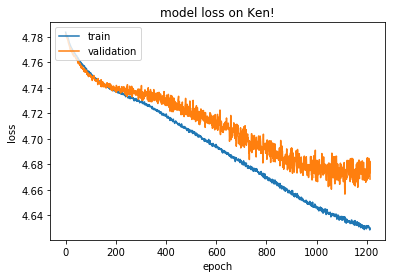

In [227]:
plot(history, title='Ken', metric='loss')

In [256]:
best_predicted_model = np.argmax( model_dense.predict( data.x[ data.region=='train' ] ), axis=1 )

In [ ]:
from scipy import stats

stats.mode(era_preds)

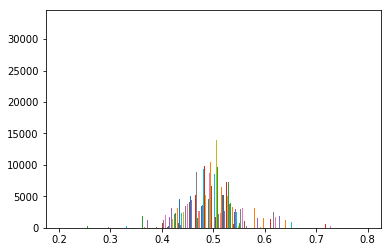

In [242]:


x = pyplot.hist(era_preds, bins=50)

In [17]:
len(era_data)

120

In [19]:
def GetEraModel(train_x, val_x, train_y, val_y ):

    model = Sequential([
        Dense(32, input_shape=(50,)),
        Activation('relu'),
        Dropout(0.3),
        Dense(100),
        Activation('relu'),
        Dense(100),
        Activation('relu'),
        Dropout(0.3),
        Dense(1),
        Activation('sigmoid'),
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_crossentropy'])

    callbacks = [EarlyStopping(monitor='val_loss', 
              min_delta=0, 
              patience=20, 
              verbose=0, 
              mode='auto', 
              baseline=None, 
              restore_best_weights=True)]
    
    history = model.fit(train_x, 
                        train_y, 
                        validation_data=(val_x,val_y), 
                        epochs=100, 
                        callbacks=callbacks,
                        batch_size=1000, 
                        shuffle=True)
    
    return (model, history)



In [20]:
%%time
era_models = era_data | select( lambda era: GetEraModel( era[0], era[1], era[2], era[3] ) ) | as_list

Train on 2854 samples, validate on 1407 samples
Epoch 1/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6979 - binary_crossentropy: 0.697 - 1s 186us/step - loss: 0.6969 - binary_crossentropy: 0.6969 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 2/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 6us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 3/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 6us/step - loss: 0.6946 - binary_crossentropy: 0.6946 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 4/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6913 - binary_crossentropy: 0.691 - 0s 5us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 5/20
2854/2854 [==============================] - ETA: 0s - loss

Epoch 18/20
2872/2872 [==============================] - ETA: 0s - loss: 0.6842 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6871 - binary_crossentropy: 0.6871 - val_loss: 0.6845 - val_binary_crossentropy: 0.6845
Epoch 19/20
2872/2872 [==============================] - ETA: 0s - loss: 0.6882 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6864 - binary_crossentropy: 0.6864 - val_loss: 0.6840 - val_binary_crossentropy: 0.6840
Epoch 20/20
2872/2872 [==============================] - ETA: 0s - loss: 0.6840 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6860 - binary_crossentropy: 0.6860 - val_loss: 0.6836 - val_binary_crossentropy: 0.6836
Train on 2937 samples, validate on 1447 samples
Epoch 1/20
2937/2937 [==============================] - ETA: 1s - loss: 0.7222 - binary_crossentropy: 0.722 - 1s 205us/step - loss: 0.7078 - binary_crossentropy: 0.7078 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 2/20
2937/2937 [==============================] - ETA: 0s - l

Epoch 15/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6844 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6875 - binary_crossentropy: 0.6875 - val_loss: 0.6828 - val_binary_crossentropy: 0.6828
Epoch 16/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6868 - binary_crossentropy: 0.6868 - val_loss: 0.6823 - val_binary_crossentropy: 0.6823
Epoch 17/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6845 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6852 - binary_crossentropy: 0.6852 - val_loss: 0.6818 - val_binary_crossentropy: 0.6818
Epoch 18/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6839 - binary_crossentropy: 0.683 - 0s 6us/step - loss: 0.6856 - binary_crossentropy: 0.6856 - val_loss: 0.6818 - val_binary_crossentropy: 0.6818
Epoch 19/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0s 6u

Epoch 12/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6896 - binary_crossentropy: 0.689 - 0s 5us/step - loss: 0.6893 - binary_crossentropy: 0.6893 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 13/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 5us/step - loss: 0.6890 - binary_crossentropy: 0.6890 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 14/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6942 - binary_crossentropy: 0.694 - 0s 5us/step - loss: 0.6900 - binary_crossentropy: 0.6900 - val_loss: 0.6913 - val_binary_crossentropy: 0.6913
Epoch 15/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 5us/step - loss: 0.6901 - binary_crossentropy: 0.6901 - val_loss: 0.6907 - val_binary_crossentropy: 0.6907
Epoch 16/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6837 - binary_crossentropy: 0.683 - 0s 5u

Epoch 9/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6936 - binary_crossentropy: 0.693 - 0s 5us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6913 - val_binary_crossentropy: 0.6913
Epoch 10/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 5us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 11/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 5us/step - loss: 0.6909 - binary_crossentropy: 0.6909 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 12/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 5us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 13/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 6us

Epoch 6/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6926 - binary_crossentropy: 0.6926 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 7/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6940 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6887 - val_binary_crossentropy: 0.6887
Epoch 8/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 5us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6884 - val_binary_crossentropy: 0.6884
Epoch 9/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 5us/step - loss: 0.6937 - binary_crossentropy: 0.6937 - val_loss: 0.6882 - val_binary_crossentropy: 0.6882
Epoch 10/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 6us/st

Epoch 3/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6973 - binary_crossentropy: 0.697 - 0s 5us/step - loss: 0.6962 - binary_crossentropy: 0.6962 - val_loss: 0.6892 - val_binary_crossentropy: 0.6892
Epoch 4/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6953 - binary_crossentropy: 0.695 - 0s 5us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6887 - val_binary_crossentropy: 0.6887
Epoch 5/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6936 - binary_crossentropy: 0.693 - 0s 5us/step - loss: 0.6946 - binary_crossentropy: 0.6946 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 6/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 5us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6886 - val_binary_crossentropy: 0.6886
Epoch 7/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 6us/ste

Epoch 20/20
3005/3005 [==============================] - ETA: 0s - loss: 0.6907 - binary_crossentropy: 0.690 - 0s 6us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6955 - val_binary_crossentropy: 0.6955
Train on 2600 samples, validate on 1282 samples
Epoch 1/20
2600/2600 [==============================] - ETA: 1s - loss: 0.6964 - binary_crossentropy: 0.696 - 1s 472us/step - loss: 0.6973 - binary_crossentropy: 0.6973 - val_loss: 0.6916 - val_binary_crossentropy: 0.6916
Epoch 2/20
2600/2600 [==============================] - ETA: 0s - loss: 0.6955 - binary_crossentropy: 0.695 - 0s 6us/step - loss: 0.6959 - binary_crossentropy: 0.6959 - val_loss: 0.6919 - val_binary_crossentropy: 0.6919
Epoch 3/20
2600/2600 [==============================] - ETA: 0s - loss: 0.6987 - binary_crossentropy: 0.698 - 0s 6us/step - loss: 0.6959 - binary_crossentropy: 0.6959 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 4/20
2600/2600 [==============================] - ETA: 0s - los

Epoch 17/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6836 - binary_crossentropy: 0.683 - 0s 6us/step - loss: 0.6850 - binary_crossentropy: 0.6850 - val_loss: 0.6765 - val_binary_crossentropy: 0.6765
Epoch 18/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6849 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6837 - binary_crossentropy: 0.6837 - val_loss: 0.6754 - val_binary_crossentropy: 0.6754
Epoch 19/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6816 - binary_crossentropy: 0.681 - 0s 6us/step - loss: 0.6807 - binary_crossentropy: 0.6807 - val_loss: 0.6791 - val_binary_crossentropy: 0.6791
Epoch 20/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6874 - binary_crossentropy: 0.687 - 0s 6us/step - loss: 0.6871 - binary_crossentropy: 0.6871 - val_loss: 0.6753 - val_binary_crossentropy: 0.6753
Train on 3135 samples, validate on 1545 samples
Epoch 1/20
3135/3135 [==============================] - ETA: 2s - lo

Epoch 14/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6742 - binary_crossentropy: 0.674 - 0s 6us/step - loss: 0.6744 - binary_crossentropy: 0.6744 - val_loss: 0.6710 - val_binary_crossentropy: 0.6710
Epoch 15/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6681 - binary_crossentropy: 0.668 - 0s 7us/step - loss: 0.6692 - binary_crossentropy: 0.6692 - val_loss: 0.6688 - val_binary_crossentropy: 0.6688
Epoch 16/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6794 - binary_crossentropy: 0.679 - 0s 7us/step - loss: 0.6741 - binary_crossentropy: 0.6741 - val_loss: 0.6672 - val_binary_crossentropy: 0.6672
Epoch 17/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6707 - binary_crossentropy: 0.670 - 0s 7us/step - loss: 0.6663 - binary_crossentropy: 0.6663 - val_loss: 0.6656 - val_binary_crossentropy: 0.6656
Epoch 18/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6681 - binary_crossentropy: 0.668 - 0s 6u

Epoch 11/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6835 - binary_crossentropy: 0.683 - 0s 5us/step - loss: 0.6856 - binary_crossentropy: 0.6856 - val_loss: 0.6819 - val_binary_crossentropy: 0.6819
Epoch 12/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6819 - binary_crossentropy: 0.681 - 0s 5us/step - loss: 0.6843 - binary_crossentropy: 0.6843 - val_loss: 0.6808 - val_binary_crossentropy: 0.6808
Epoch 13/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 5us/step - loss: 0.6849 - binary_crossentropy: 0.6849 - val_loss: 0.6802 - val_binary_crossentropy: 0.6802
Epoch 14/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6809 - binary_crossentropy: 0.680 - 0s 5us/step - loss: 0.6807 - binary_crossentropy: 0.6807 - val_loss: 0.6804 - val_binary_crossentropy: 0.6804
Epoch 15/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6792 - binary_crossentropy: 0.679 - 0s 5u

Epoch 8/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 6us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6915 - val_binary_crossentropy: 0.6915
Epoch 9/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 6us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6912 - val_binary_crossentropy: 0.6912
Epoch 10/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 5us/step - loss: 0.6920 - binary_crossentropy: 0.6920 - val_loss: 0.6908 - val_binary_crossentropy: 0.6908
Epoch 11/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6896 - binary_crossentropy: 0.689 - 0s 5us/step - loss: 0.6904 - binary_crossentropy: 0.6904 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 12/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 7us/

Epoch 5/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6920 - binary_crossentropy: 0.6920 - val_loss: 0.6900 - val_binary_crossentropy: 0.6900
Epoch 6/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6905 - binary_crossentropy: 0.6905 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 7/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 7us/step - loss: 0.6886 - binary_crossentropy: 0.6886 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 8/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6887 - binary_crossentropy: 0.688 - 0s 7us/step - loss: 0.6883 - binary_crossentropy: 0.6883 - val_loss: 0.6914 - val_binary_crossentropy: 0.6914
Epoch 9/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6846 - binary_crossentropy: 0.684 - 0s 7us/ste

Epoch 2/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6981 - binary_crossentropy: 0.698 - 0s 6us/step - loss: 0.7009 - binary_crossentropy: 0.7009 - val_loss: 0.6957 - val_binary_crossentropy: 0.6957
Epoch 3/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6963 - binary_crossentropy: 0.696 - 0s 6us/step - loss: 0.6947 - binary_crossentropy: 0.6947 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 4/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6944 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6936 - binary_crossentropy: 0.6936 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 5/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6949 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 6/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6934 - binary_crossentropy: 0.693 - 0s 6us/ste

Epoch 19/20
3236/3236 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 20/20
3236/3236 [==============================] - ETA: 0s - loss: 0.6907 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6895 - binary_crossentropy: 0.6895 - val_loss: 0.6919 - val_binary_crossentropy: 0.6919
Train on 3134 samples, validate on 1545 samples
Epoch 1/20
3134/3134 [==============================] - ETA: 3s - loss: 0.6986 - binary_crossentropy: 0.698 - 2s 627us/step - loss: 0.6970 - binary_crossentropy: 0.6970 - val_loss: 0.6928 - val_binary_crossentropy: 0.6928
Epoch 2/20
3134/3134 [==============================] - ETA: 0s - loss: 0.6976 - binary_crossentropy: 0.697 - 0s 7us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6943 - val_binary_crossentropy: 0.6943
Epoch 3/20
3134/3134 [==============================] - ETA: 0s - lo

Epoch 16/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6926 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6928 - binary_crossentropy: 0.6928 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889
Epoch 17/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6890 - val_binary_crossentropy: 0.6890
Epoch 18/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6910 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6903 - binary_crossentropy: 0.6903 - val_loss: 0.6893 - val_binary_crossentropy: 0.6893
Epoch 19/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6905 - binary_crossentropy: 0.6905 - val_loss: 0.6894 - val_binary_crossentropy: 0.6894
Epoch 20/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6892 - binary_crossentropy: 0.689 - 0s 7u

Epoch 13/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6891 - binary_crossentropy: 0.6891 - val_loss: 0.6863 - val_binary_crossentropy: 0.6863
Epoch 14/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6889 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6901 - binary_crossentropy: 0.6901 - val_loss: 0.6859 - val_binary_crossentropy: 0.6859
Epoch 15/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6861 - val_binary_crossentropy: 0.6861
Epoch 16/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6853 - binary_crossentropy: 0.685 - 0s 6us/step - loss: 0.6864 - binary_crossentropy: 0.6864 - val_loss: 0.6853 - val_binary_crossentropy: 0.6853
Epoch 17/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6849 - binary_crossentropy: 0.684 - 0s 6u

Epoch 10/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6879 - binary_crossentropy: 0.687 - 0s 7us/step - loss: 0.6910 - binary_crossentropy: 0.6910 - val_loss: 0.6897 - val_binary_crossentropy: 0.6897
Epoch 11/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6902 - binary_crossentropy: 0.6902 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889
Epoch 12/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6920 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6926 - binary_crossentropy: 0.6926 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889
Epoch 13/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6894 - binary_crossentropy: 0.689 - 0s 6us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6885 - val_binary_crossentropy: 0.6885
Epoch 14/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6894 - binary_crossentropy: 0.689 - 0s 6u

Epoch 7/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6970 - binary_crossentropy: 0.697 - 0s 7us/step - loss: 0.6943 - binary_crossentropy: 0.6943 - val_loss: 0.6944 - val_binary_crossentropy: 0.6944
Epoch 8/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6910 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 9/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6956 - binary_crossentropy: 0.695 - 0s 7us/step - loss: 0.6949 - binary_crossentropy: 0.6949 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 10/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 11/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 7us/s

Epoch 4/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6960 - binary_crossentropy: 0.696 - 0s 7us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 5/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6968 - binary_crossentropy: 0.696 - 0s 7us/step - loss: 0.6936 - binary_crossentropy: 0.6936 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 6/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 7/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 8/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 7us/ste

Train on 2283 samples, validate on 1125 samples
Epoch 1/20
2283/2283 [==============================] - ETA: 3s - loss: 0.6949 - binary_crossentropy: 0.694 - 3s 1ms/step - loss: 0.6944 - binary_crossentropy: 0.6944 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 2/20
2283/2283 [==============================] - ETA: 0s - loss: 0.6959 - binary_crossentropy: 0.695 - 0s 9us/step - loss: 0.6953 - binary_crossentropy: 0.6953 - val_loss: 0.6914 - val_binary_crossentropy: 0.6914
Epoch 3/20
2283/2283 [==============================] - ETA: 0s - loss: 0.6951 - binary_crossentropy: 0.695 - 0s 8us/step - loss: 0.6942 - binary_crossentropy: 0.6942 - val_loss: 0.6898 - val_binary_crossentropy: 0.6898
Epoch 4/20
2283/2283 [==============================] - ETA: 0s - loss: 0.6953 - binary_crossentropy: 0.695 - 0s 9us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6890 - val_binary_crossentropy: 0.6890
Epoch 5/20
2283/2283 [==============================] - ETA: 0s - loss: 

Epoch 18/20
3042/3042 [==============================] - ETA: 0s - loss: 0.6873 - binary_crossentropy: 0.687 - 0s 8us/step - loss: 0.6833 - binary_crossentropy: 0.6833 - val_loss: 0.6772 - val_binary_crossentropy: 0.6772
Epoch 19/20
3042/3042 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 7us/step - loss: 0.6855 - binary_crossentropy: 0.6855 - val_loss: 0.6771 - val_binary_crossentropy: 0.6771
Epoch 20/20
3042/3042 [==============================] - ETA: 0s - loss: 0.6789 - binary_crossentropy: 0.678 - 0s 7us/step - loss: 0.6833 - binary_crossentropy: 0.6833 - val_loss: 0.6783 - val_binary_crossentropy: 0.6783
Train on 3209 samples, validate on 1582 samples
Epoch 1/20
3209/3209 [==============================] - ETA: 5s - loss: 0.6964 - binary_crossentropy: 0.696 - 3s 877us/step - loss: 0.6930 - binary_crossentropy: 0.6930 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 2/20
3209/3209 [==============================] - ETA: 0s - l

Epoch 15/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6874 - val_binary_crossentropy: 0.6874
Epoch 16/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 8us/step - loss: 0.6882 - binary_crossentropy: 0.6882 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Epoch 17/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 9us/step - loss: 0.6899 - binary_crossentropy: 0.6899 - val_loss: 0.6864 - val_binary_crossentropy: 0.6864
Epoch 18/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6867 - binary_crossentropy: 0.686 - 0s 8us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6856 - val_binary_crossentropy: 0.6856
Epoch 19/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6858 - binary_crossentropy: 0.685 - 0s 8u

Epoch 12/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6900 - binary_crossentropy: 0.690 - 0s 6us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 13/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6930 - binary_crossentropy: 0.6930 - val_loss: 0.6924 - val_binary_crossentropy: 0.6924
Epoch 14/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6911 - binary_crossentropy: 0.6911 - val_loss: 0.6924 - val_binary_crossentropy: 0.6924
Epoch 15/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6923 - val_binary_crossentropy: 0.6923
Epoch 16/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 7u

Epoch 9/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 6us/step - loss: 0.6925 - binary_crossentropy: 0.6925 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 10/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6926 - binary_crossentropy: 0.692 - 0s 6us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6918 - val_binary_crossentropy: 0.6918
Epoch 11/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6942 - binary_crossentropy: 0.694 - 0s 7us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6916 - val_binary_crossentropy: 0.6916
Epoch 12/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6919 - binary_crossentropy: 0.691 - 0s 6us/step - loss: 0.6911 - binary_crossentropy: 0.6911 - val_loss: 0.6914 - val_binary_crossentropy: 0.6914
Epoch 13/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 6us

Epoch 6/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6931 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6967 - binary_crossentropy: 0.6967 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 7/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6983 - binary_crossentropy: 0.698 - 0s 8us/step - loss: 0.6957 - binary_crossentropy: 0.6957 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 8/20
3287/3287 [==============================] - ETA: 0s - loss: 0.7013 - binary_crossentropy: 0.701 - 0s 7us/step - loss: 0.6962 - binary_crossentropy: 0.6962 - val_loss: 0.6927 - val_binary_crossentropy: 0.6927
Epoch 9/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6927 - val_binary_crossentropy: 0.6927
Epoch 10/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 7us/st

Epoch 3/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6954 - binary_crossentropy: 0.695 - 0s 7us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6946 - val_binary_crossentropy: 0.6946
Epoch 4/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 8us/step - loss: 0.6958 - binary_crossentropy: 0.6958 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 5/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 7us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 6/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 7/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6919 - binary_crossentropy: 0.691 - 0s 6us/ste

Epoch 20/20
2830/2830 [==============================] - ETA: 0s - loss: 0.6884 - binary_crossentropy: 0.688 - 0s 7us/step - loss: 0.6887 - binary_crossentropy: 0.6887 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Train on 3148 samples, validate on 1551 samples
Epoch 1/20
3148/3148 [==============================] - ETA: 6s - loss: 0.6982 - binary_crossentropy: 0.698 - 4s 1ms/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 2/20
3148/3148 [==============================] - ETA: 0s - loss: 0.6969 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 3/20
3148/3148 [==============================] - ETA: 0s - loss: 0.6948 - binary_crossentropy: 0.694 - 0s 9us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 4/20
3148/3148 [==============================] - ETA: 0s - loss:

Epoch 17/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6928 - binary_crossentropy: 0.6928 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 18/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 7us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6908 - val_binary_crossentropy: 0.6908
Epoch 19/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 7us/step - loss: 0.6903 - binary_crossentropy: 0.6903 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 20/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6901 - val_binary_crossentropy: 0.6901
Train on 2568 samples, validate on 1265 samples
Epoch 1/20
2568/2568 [==============================] - ETA: 5s - lo

Epoch 14/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6947 - binary_crossentropy: 0.694 - 0s 8us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6941 - val_binary_crossentropy: 0.6941
Epoch 15/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6919 - binary_crossentropy: 0.6919 - val_loss: 0.6940 - val_binary_crossentropy: 0.6940
Epoch 16/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6939 - val_binary_crossentropy: 0.6939
Epoch 17/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6945 - binary_crossentropy: 0.694 - 0s 9us/step - loss: 0.6939 - binary_crossentropy: 0.6939 - val_loss: 0.6939 - val_binary_crossentropy: 0.6939
Epoch 18/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 8u

Epoch 11/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6904 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6915 - binary_crossentropy: 0.6915 - val_loss: 0.6908 - val_binary_crossentropy: 0.6908
Epoch 12/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 8us/step - loss: 0.6916 - binary_crossentropy: 0.6916 - val_loss: 0.6907 - val_binary_crossentropy: 0.6907
Epoch 13/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6936 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6929 - binary_crossentropy: 0.6929 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 14/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 11us/step - loss: 0.6908 - binary_crossentropy: 0.6908 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 15/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6920 - binary_crossentropy: 0.692 - 0s 8

Epoch 8/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6876 - binary_crossentropy: 0.687 - 0s 10us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6866 - val_binary_crossentropy: 0.6866
Epoch 9/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6868 - binary_crossentropy: 0.686 - 0s 9us/step - loss: 0.6870 - binary_crossentropy: 0.6870 - val_loss: 0.6852 - val_binary_crossentropy: 0.6852
Epoch 10/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6870 - binary_crossentropy: 0.687 - 0s 9us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6842 - val_binary_crossentropy: 0.6842
Epoch 11/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6867 - binary_crossentropy: 0.686 - 0s 8us/step - loss: 0.6842 - binary_crossentropy: 0.6842 - val_loss: 0.6835 - val_binary_crossentropy: 0.6835
Epoch 12/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6842 - binary_crossentropy: 0.684 - 0s 8us

Epoch 5/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 10us/step - loss: 0.6900 - binary_crossentropy: 0.6900 - val_loss: 0.6877 - val_binary_crossentropy: 0.6877
Epoch 6/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0s 9us/step - loss: 0.6890 - binary_crossentropy: 0.6890 - val_loss: 0.6872 - val_binary_crossentropy: 0.6872
Epoch 7/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 9us/step - loss: 0.6888 - binary_crossentropy: 0.6888 - val_loss: 0.6870 - val_binary_crossentropy: 0.6870
Epoch 8/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6878 - binary_crossentropy: 0.687 - 0s 10us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6870 - val_binary_crossentropy: 0.6870
Epoch 9/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 10us/

Epoch 2/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6978 - binary_crossentropy: 0.697 - 0s 10us/step - loss: 0.6959 - binary_crossentropy: 0.6959 - val_loss: 0.6941 - val_binary_crossentropy: 0.6941
Epoch 3/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6957 - binary_crossentropy: 0.695 - 0s 10us/step - loss: 0.6983 - binary_crossentropy: 0.6983 - val_loss: 0.6956 - val_binary_crossentropy: 0.6956
Epoch 4/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6978 - binary_crossentropy: 0.6978 - val_loss: 0.6947 - val_binary_crossentropy: 0.6947
Epoch 5/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6942 - binary_crossentropy: 0.6942 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 6/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6956 - binary_crossentropy: 0.695 - 0s 9us/

Epoch 19/20
2646/2646 [==============================] - ETA: 0s - loss: 0.6876 - binary_crossentropy: 0.687 - 0s 8us/step - loss: 0.6891 - binary_crossentropy: 0.6891 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 20/20
2646/2646 [==============================] - ETA: 0s - loss: 0.6880 - binary_crossentropy: 0.688 - 0s 8us/step - loss: 0.6879 - binary_crossentropy: 0.6879 - val_loss: 0.6884 - val_binary_crossentropy: 0.6884
Train on 2828 samples, validate on 1394 samples
Epoch 1/20
2828/2828 [==============================] - ETA: 7s - loss: 0.7011 - binary_crossentropy: 0.701 - 4s 2ms/step - loss: 0.6995 - binary_crossentropy: 0.6995 - val_loss: 0.6949 - val_binary_crossentropy: 0.6949
Epoch 2/20
2828/2828 [==============================] - ETA: 0s - loss: 0.6916 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6961 - binary_crossentropy: 0.6961 - val_loss: 0.6972 - val_binary_crossentropy: 0.6972
Epoch 3/20
2828/2828 [==============================] - ETA: 0s - los

Epoch 16/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6854 - binary_crossentropy: 0.685 - 0s 8us/step - loss: 0.6867 - binary_crossentropy: 0.6867 - val_loss: 0.6811 - val_binary_crossentropy: 0.6811
Epoch 17/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6862 - binary_crossentropy: 0.686 - 0s 8us/step - loss: 0.6876 - binary_crossentropy: 0.6876 - val_loss: 0.6805 - val_binary_crossentropy: 0.6805
Epoch 18/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6847 - binary_crossentropy: 0.684 - 0s 9us/step - loss: 0.6856 - binary_crossentropy: 0.6856 - val_loss: 0.6803 - val_binary_crossentropy: 0.6803
Epoch 19/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6819 - binary_crossentropy: 0.681 - 0s 8us/step - loss: 0.6818 - binary_crossentropy: 0.6818 - val_loss: 0.6792 - val_binary_crossentropy: 0.6792
Epoch 20/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6873 - binary_crossentropy: 0.687 - 0s 8u

Epoch 13/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6937 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 14/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6931 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6937 - binary_crossentropy: 0.6937 - val_loss: 0.6927 - val_binary_crossentropy: 0.6927
Epoch 15/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6934 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6946 - binary_crossentropy: 0.6946 - val_loss: 0.6934 - val_binary_crossentropy: 0.6934
Epoch 16/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6964 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6958 - binary_crossentropy: 0.6958 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 17/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6943 - binary_crossentropy: 0.694 - 0s 9u

Epoch 10/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6924 - val_binary_crossentropy: 0.6924
Epoch 11/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6957 - binary_crossentropy: 0.695 - 0s 9us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 12/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6913 - val_binary_crossentropy: 0.6913
Epoch 13/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6926 - binary_crossentropy: 0.6926 - val_loss: 0.6912 - val_binary_crossentropy: 0.6912
Epoch 14/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 9u

Epoch 7/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6908 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6916 - binary_crossentropy: 0.6916 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 8/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6938 - binary_crossentropy: 0.693 - 0s 10us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 9/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 10us/step - loss: 0.6950 - binary_crossentropy: 0.6950 - val_loss: 0.6912 - val_binary_crossentropy: 0.6912
Epoch 10/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 8us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 11/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6956 - binary_crossentropy: 0.695 - 0s 9us

Epoch 4/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6958 - binary_crossentropy: 0.695 - 0s 8us/step - loss: 0.6962 - binary_crossentropy: 0.6962 - val_loss: 0.6944 - val_binary_crossentropy: 0.6944
Epoch 5/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6938 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 6/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6911 - val_binary_crossentropy: 0.6911
Epoch 7/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 8us/step - loss: 0.6906 - binary_crossentropy: 0.6906 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 8/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6912 - binary_crossentropy: 0.691 - 0s 8us/ste

Train on 2660 samples, validate on 1311 samples
Epoch 1/20
2660/2660 [==============================] - ETA: 7s - loss: 0.6906 - binary_crossentropy: 0.690 - 5s 2ms/step - loss: 0.6939 - binary_crossentropy: 0.6939 - val_loss: 0.6954 - val_binary_crossentropy: 0.6954
Epoch 2/20
2660/2660 [==============================] - ETA: 0s - loss: 0.6967 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6955 - binary_crossentropy: 0.6955 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 3/20
2660/2660 [==============================] - ETA: 0s - loss: 0.6937 - binary_crossentropy: 0.693 - 0s 11us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 4/20
2660/2660 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6902 - val_binary_crossentropy: 0.6902
Epoch 5/20
2660/2660 [==============================] - ETA: 0s - loss:

Epoch 18/20
3132/3132 [==============================] - ETA: 0s - loss: 0.6939 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6877 - val_binary_crossentropy: 0.6877
Epoch 19/20
3132/3132 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 8us/step - loss: 0.6895 - binary_crossentropy: 0.6895 - val_loss: 0.6871 - val_binary_crossentropy: 0.6871
Epoch 20/20
3132/3132 [==============================] - ETA: 0s - loss: 0.6870 - binary_crossentropy: 0.687 - 0s 9us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Train on 1811 samples, validate on 892 samples
Epoch 1/20
1811/1811 [==============================] - ETA: 3s - loss: 0.6953 - binary_crossentropy: 0.695 - 5s 3ms/step - loss: 0.6944 - binary_crossentropy: 0.6944 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 2/20
1811/1811 [==============================] - ETA: 0s - loss

Epoch 15/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6957 - binary_crossentropy: 0.695 - 0s 10us/step - loss: 0.6939 - binary_crossentropy: 0.6939 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 16/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6937 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 17/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 18/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6937 - binary_crossentropy: 0.6937 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 19/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 

Epoch 12/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6952 - binary_crossentropy: 0.695 - 0s 13us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 13/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 14/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6940 - binary_crossentropy: 0.694 - 0s 11us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 15/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6935 - val_binary_crossentropy: 0.6935
Epoch 16/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6938 - binary_crossentropy: 0.693 - 0

Epoch 9/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6903 - binary_crossentropy: 0.6903 - val_loss: 0.6878 - val_binary_crossentropy: 0.6878
Epoch 10/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 10us/step - loss: 0.6884 - binary_crossentropy: 0.6884 - val_loss: 0.6870 - val_binary_crossentropy: 0.6870
Epoch 11/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 10us/step - loss: 0.6882 - binary_crossentropy: 0.6882 - val_loss: 0.6869 - val_binary_crossentropy: 0.6869
Epoch 12/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6903 - binary_crossentropy: 0.690 - 0s 10us/step - loss: 0.6900 - binary_crossentropy: 0.6900 - val_loss: 0.6872 - val_binary_crossentropy: 0.6872
Epoch 13/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s

Epoch 6/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6800 - binary_crossentropy: 0.680 - 0s 9us/step - loss: 0.6809 - binary_crossentropy: 0.6809 - val_loss: 0.6785 - val_binary_crossentropy: 0.6785
Epoch 7/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6800 - binary_crossentropy: 0.680 - 0s 10us/step - loss: 0.6812 - binary_crossentropy: 0.6812 - val_loss: 0.6790 - val_binary_crossentropy: 0.6790
Epoch 8/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6722 - binary_crossentropy: 0.672 - 0s 10us/step - loss: 0.6750 - binary_crossentropy: 0.6750 - val_loss: 0.6763 - val_binary_crossentropy: 0.6763
Epoch 9/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6677 - binary_crossentropy: 0.667 - 0s 9us/step - loss: 0.6736 - binary_crossentropy: 0.6736 - val_loss: 0.6757 - val_binary_crossentropy: 0.6757
Epoch 10/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6707 - binary_crossentropy: 0.670 - 0s 9us/

Epoch 3/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 9us/step - loss: 0.6899 - binary_crossentropy: 0.6899 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 4/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6953 - binary_crossentropy: 0.695 - 0s 8us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6881 - val_binary_crossentropy: 0.6881
Epoch 5/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6879 - binary_crossentropy: 0.687 - 0s 9us/step - loss: 0.6882 - binary_crossentropy: 0.6882 - val_loss: 0.6871 - val_binary_crossentropy: 0.6871
Epoch 6/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6904 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Epoch 7/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6903 - binary_crossentropy: 0.690 - 0s 9us/ste

Epoch 20/20
2960/2960 [==============================] - ETA: 0s - loss: 0.6896 - binary_crossentropy: 0.689 - 0s 9us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6895 - val_binary_crossentropy: 0.6895
Train on 3261 samples, validate on 1607 samples
Epoch 1/20
3261/3261 [==============================] - ETA: 12s - loss: 0.7130 - binary_crossentropy: 0.71 - 6s 2ms/step - loss: 0.7029 - binary_crossentropy: 0.7029 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 2/20
3261/3261 [==============================] - ETA: 0s - loss: 0.6968 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6976 - binary_crossentropy: 0.6976 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 3/20
3261/3261 [==============================] - ETA: 0s - loss: 0.6966 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6934 - binary_crossentropy: 0.6934 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 4/20
3261/3261 [==============================] - ETA: 0s - los

Epoch 17/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6778 - binary_crossentropy: 0.677 - 0s 8us/step - loss: 0.6812 - binary_crossentropy: 0.6812 - val_loss: 0.6754 - val_binary_crossentropy: 0.6754
Epoch 18/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6790 - binary_crossentropy: 0.679 - 0s 8us/step - loss: 0.6801 - binary_crossentropy: 0.6801 - val_loss: 0.6750 - val_binary_crossentropy: 0.6750
Epoch 19/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6782 - binary_crossentropy: 0.678 - 0s 10us/step - loss: 0.6796 - binary_crossentropy: 0.6796 - val_loss: 0.6745 - val_binary_crossentropy: 0.6745
Epoch 20/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6787 - binary_crossentropy: 0.678 - 0s 9us/step - loss: 0.6810 - binary_crossentropy: 0.6810 - val_loss: 0.6738 - val_binary_crossentropy: 0.6738
Train on 2972 samples, validate on 1464 samples
Epoch 1/20
2972/2972 [==============================] - ETA: 10s - 

Epoch 14/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6818 - val_binary_crossentropy: 0.6818
Epoch 15/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6904 - binary_crossentropy: 0.690 - 0s 10us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6817 - val_binary_crossentropy: 0.6817
Epoch 16/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6850 - binary_crossentropy: 0.685 - 0s 11us/step - loss: 0.6861 - binary_crossentropy: 0.6861 - val_loss: 0.6841 - val_binary_crossentropy: 0.6841
Epoch 17/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6857 - binary_crossentropy: 0.685 - 0s 11us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6835 - val_binary_crossentropy: 0.6835
Epoch 18/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0

Epoch 11/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6916 - binary_crossentropy: 0.691 - 0s 9us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 12/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6935 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 13/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6943 - binary_crossentropy: 0.694 - 0s 9us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6919 - val_binary_crossentropy: 0.6919
Epoch 14/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 15/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 9

Epoch 8/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6899 - binary_crossentropy: 0.689 - 0s 11us/step - loss: 0.6908 - binary_crossentropy: 0.6908 - val_loss: 0.6961 - val_binary_crossentropy: 0.6961
Epoch 9/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6912 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6968 - val_binary_crossentropy: 0.6968
Epoch 10/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6906 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6963 - val_binary_crossentropy: 0.6963
Epoch 11/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6918 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6947 - val_binary_crossentropy: 0.6947
Epoch 12/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 1

Epoch 5/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6919 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6920 - binary_crossentropy: 0.6920 - val_loss: 0.6935 - val_binary_crossentropy: 0.6935
Epoch 6/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 11us/step - loss: 0.6925 - binary_crossentropy: 0.6925 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 7/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6880 - binary_crossentropy: 0.688 - 0s 11us/step - loss: 0.6911 - binary_crossentropy: 0.6911 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 8/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6913 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6913 - binary_crossentropy: 0.6913 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 9/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 10u

Epoch 2/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6989 - binary_crossentropy: 0.698 - 0s 10us/step - loss: 0.6973 - binary_crossentropy: 0.6973 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 3/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6954 - binary_crossentropy: 0.695 - 0s 10us/step - loss: 0.6958 - binary_crossentropy: 0.6958 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 4/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 5/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6968 - binary_crossentropy: 0.696 - 0s 8us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 6/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6939 - binary_crossentropy: 0.693 - 0s 8us/

Epoch 19/20
2923/2923 [==============================] - ETA: 0s - loss: 0.6906 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6880 - binary_crossentropy: 0.6880 - val_loss: 0.6871 - val_binary_crossentropy: 0.6871
Epoch 20/20
2923/2923 [==============================] - ETA: 0s - loss: 0.6852 - binary_crossentropy: 0.685 - 0s 10us/step - loss: 0.6867 - binary_crossentropy: 0.6867 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Train on 2958 samples, validate on 1458 samples
Epoch 1/20
2958/2958 [==============================] - ETA: 12s - loss: 0.6955 - binary_crossentropy: 0.69 - 7s 2ms/step - loss: 0.6970 - binary_crossentropy: 0.6970 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 2/20
2958/2958 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6950 - binary_crossentropy: 0.6950 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 3/20
2958/2958 [==============================] - ETA: 0s - los

Epoch 16/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6880 - binary_crossentropy: 0.688 - 0s 11us/step - loss: 0.6825 - binary_crossentropy: 0.6825 - val_loss: 0.6786 - val_binary_crossentropy: 0.6786
Epoch 17/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6839 - binary_crossentropy: 0.683 - 0s 11us/step - loss: 0.6822 - binary_crossentropy: 0.6822 - val_loss: 0.6783 - val_binary_crossentropy: 0.6783
Epoch 18/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6779 - binary_crossentropy: 0.677 - 0s 12us/step - loss: 0.6797 - binary_crossentropy: 0.6797 - val_loss: 0.6763 - val_binary_crossentropy: 0.6763
Epoch 19/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6760 - binary_crossentropy: 0.676 - 0s 11us/step - loss: 0.6799 - binary_crossentropy: 0.6799 - val_loss: 0.6762 - val_binary_crossentropy: 0.6762
Epoch 20/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6826 - binary_crossentropy: 0.682 - 0

Epoch 13/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 12us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 14/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6943 - binary_crossentropy: 0.694 - 0s 12us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 15/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 13us/step - loss: 0.6929 - binary_crossentropy: 0.6929 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 16/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0s 13us/step - loss: 0.6913 - binary_crossentropy: 0.6913 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 17/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0

Epoch 10/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6878 - binary_crossentropy: 0.687 - 0s 10us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 11/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6886 - binary_crossentropy: 0.688 - 0s 10us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 12/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 11us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6900 - val_binary_crossentropy: 0.6900
Epoch 13/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 12us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6898 - val_binary_crossentropy: 0.6898
Epoch 14/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0

Epoch 7/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 12us/step - loss: 0.6925 - binary_crossentropy: 0.6925 - val_loss: 0.6944 - val_binary_crossentropy: 0.6944
Epoch 8/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6909 - binary_crossentropy: 0.6909 - val_loss: 0.6939 - val_binary_crossentropy: 0.6939
Epoch 9/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6920 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 10/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6913 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6946 - val_binary_crossentropy: 0.6946
Epoch 11/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6940 - binary_crossentropy: 0.694 - 0s 9u

Epoch 4/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6912 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6826 - val_binary_crossentropy: 0.6826
Epoch 5/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6814 - binary_crossentropy: 0.681 - 0s 13us/step - loss: 0.6843 - binary_crossentropy: 0.6843 - val_loss: 0.6796 - val_binary_crossentropy: 0.6796
Epoch 6/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6812 - binary_crossentropy: 0.681 - 0s 12us/step - loss: 0.6829 - binary_crossentropy: 0.6829 - val_loss: 0.6759 - val_binary_crossentropy: 0.6759
Epoch 7/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6830 - binary_crossentropy: 0.683 - 0s 12us/step - loss: 0.6796 - binary_crossentropy: 0.6796 - val_loss: 0.6733 - val_binary_crossentropy: 0.6733
Epoch 8/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6774 - binary_crossentropy: 0.677 - 0s 10u

Train on 2898 samples, validate on 1428 samples
Epoch 1/20
2898/2898 [==============================] - ETA: 13s - loss: 0.6956 - binary_crossentropy: 0.69 - 8s 3ms/step - loss: 0.6984 - binary_crossentropy: 0.6984 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 2/20
2898/2898 [==============================] - ETA: 0s - loss: 0.6990 - binary_crossentropy: 0.699 - 0s 11us/step - loss: 0.6954 - binary_crossentropy: 0.6954 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 3/20
2898/2898 [==============================] - ETA: 0s - loss: 0.6989 - binary_crossentropy: 0.698 - 0s 10us/step - loss: 0.6944 - binary_crossentropy: 0.6944 - val_loss: 0.6923 - val_binary_crossentropy: 0.6923
Epoch 4/20
2898/2898 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 5/20
2898/2898 [==============================] - ETA: 0s - los

Epoch 18/20
3049/3049 [==============================] - ETA: 0s - loss: 0.6865 - binary_crossentropy: 0.686 - 0s 12us/step - loss: 0.6837 - binary_crossentropy: 0.6837 - val_loss: 0.6808 - val_binary_crossentropy: 0.6808
Epoch 19/20
3049/3049 [==============================] - ETA: 0s - loss: 0.6827 - binary_crossentropy: 0.682 - 0s 13us/step - loss: 0.6842 - binary_crossentropy: 0.6842 - val_loss: 0.6775 - val_binary_crossentropy: 0.6775
Epoch 20/20
3049/3049 [==============================] - ETA: 0s - loss: 0.6810 - binary_crossentropy: 0.681 - 0s 14us/step - loss: 0.6806 - binary_crossentropy: 0.6806 - val_loss: 0.6756 - val_binary_crossentropy: 0.6756
Train on 2297 samples, validate on 1132 samples
Epoch 1/20
2297/2297 [==============================] - ETA: 9s - loss: 0.6982 - binary_crossentropy: 0.698 - 8s 3ms/step - loss: 0.6964 - binary_crossentropy: 0.6964 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 2/20
2297/2297 [==============================] - ETA: 0s - 

Epoch 15/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6834 - binary_crossentropy: 0.683 - 0s 10us/step - loss: 0.6769 - binary_crossentropy: 0.6769 - val_loss: 0.6708 - val_binary_crossentropy: 0.6708
Epoch 16/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6780 - binary_crossentropy: 0.678 - 0s 12us/step - loss: 0.6757 - binary_crossentropy: 0.6757 - val_loss: 0.6696 - val_binary_crossentropy: 0.6696
Epoch 17/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6726 - binary_crossentropy: 0.672 - 0s 12us/step - loss: 0.6748 - binary_crossentropy: 0.6748 - val_loss: 0.6682 - val_binary_crossentropy: 0.6682
Epoch 18/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6746 - binary_crossentropy: 0.674 - 0s 11us/step - loss: 0.6751 - binary_crossentropy: 0.6751 - val_loss: 0.6682 - val_binary_crossentropy: 0.6682
Epoch 19/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6742 - binary_crossentropy: 0.674 - 0

Epoch 12/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 12us/step - loss: 0.6945 - binary_crossentropy: 0.6945 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 13/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 14us/step - loss: 0.6913 - binary_crossentropy: 0.6913 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 14/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 11us/step - loss: 0.6919 - binary_crossentropy: 0.6919 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 15/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 11us/step - loss: 0.6930 - binary_crossentropy: 0.6930 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 16/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0

Epoch 9/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6901 - val_binary_crossentropy: 0.6901
Epoch 10/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 12us/step - loss: 0.6910 - binary_crossentropy: 0.6910 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 11/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 15us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6890 - val_binary_crossentropy: 0.6890
Epoch 12/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 14us/step - loss: 0.6899 - binary_crossentropy: 0.6899 - val_loss: 0.6892 - val_binary_crossentropy: 0.6892
Epoch 13/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6906 - binary_crossentropy: 0.690 - 0s

In [1]:
plot(era_models[100][1])

NameError: name 'plot' is not defined

In [253]:
%%time
#era_models[119]
# now do a bunch of predictions

XV = data.x[ data.region=='validation' ]
YV = data.y[3][data.region=='validation']

# which era model to use per sample
M = np.argmax( model_dense.predict( data.x[ data.region=='validation' ] ), axis=1 )


Wall time: 5.29 s


In [149]:
from sklearn.metrics import log_loss

In [241]:
%%time

# precompute predictions + losses for every example in the validation set for all eras
# seems inefficient but due to vectorization of prediction this is likely much faster
# seems to take about 6 seconds per era for 56084 signals in validation

num_val = XV.shape[0]
num_eras = len(era_models)
era_preds = np.zeros( (num_val, num_eras ) )

for era in range(num_eras):
    
    preds = era_models[era][0].predict( XV ).reshape(-1)
    
    era_preds[:, era] = preds
    
    print('computed era: %d' % era )
    

computed era: 0
computed era: 1
computed era: 2
computed era: 3
computed era: 4
computed era: 5
computed era: 6
computed era: 7
computed era: 8
computed era: 9
computed era: 10
computed era: 11
computed era: 12
computed era: 13
computed era: 14
computed era: 15
computed era: 16
computed era: 17
computed era: 18
computed era: 19
computed era: 20
computed era: 21
computed era: 22
computed era: 23
computed era: 24
computed era: 25
computed era: 26
computed era: 27
computed era: 28
computed era: 29
computed era: 30
computed era: 31
computed era: 32
computed era: 33
computed era: 34
computed era: 35
computed era: 36
computed era: 37
computed era: 38
computed era: 39
computed era: 40
computed era: 41
computed era: 42
computed era: 43
computed era: 44
computed era: 45
computed era: 46
computed era: 47
computed era: 48
computed era: 49
computed era: 50
computed era: 51
computed era: 52
computed era: 53
computed era: 54
computed era: 55
computed era: 56
computed era: 57
computed era: 58
compute

In [239]:
num_val

56084

In [237]:
len(list(M-1))

56084

In [247]:
era_preds.shape

(56084, 120)

In [252]:
%%time

best_preds = era_preds[ list(range(era_preds.shape[0])), list(M-1)]

# calculate loss from the best PREDICTED era model
losses = log_loss( YV, best_preds )

print( losses )

x=pyplot.hist(best_preds, bins=50)

0.7059591085694358
Wall time: 34 ms


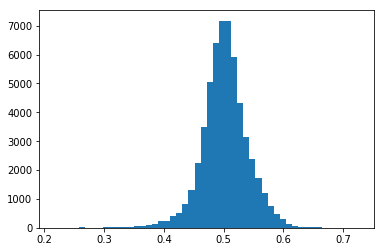

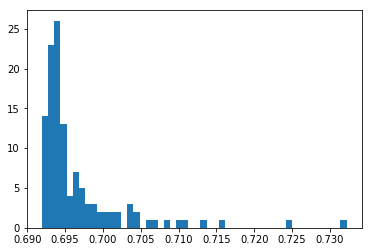

In [178]:
# what about taking all random preds from all eras, we expect this to be worse

era_losses = range(120) \
    |  select( lambda e: log_loss( YV, era_preds[:,e] ) ) \
    |  select( lambda e: np.mean(e) ) \
    |  as_list()

x=pyplot.hist(era_losses, bins=50)

0.4517104292358132
Wall time: 399 ms


array([111,  43, 117, ...,  43, 109,  18], dtype=int64)

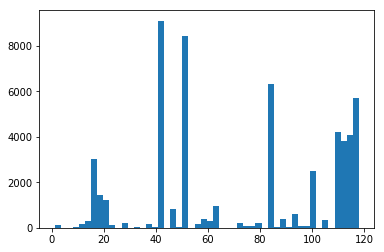

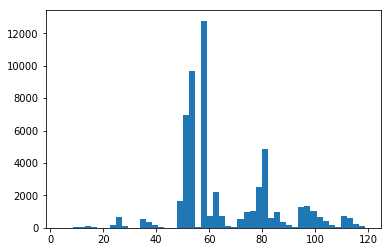

In [219]:
# there is similar regionality on the predicted best era models 
# so we can tell that the data is in era order, but unfortunatley
# it also shows us that our era prediction is comically poor!

x=pyplot.hist(M-1, bins=50)

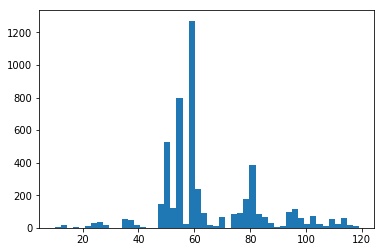

In [221]:
# lets try this on the live dataset

# which era model to use per sample
M = np.argmax( model_dense.predict( data.x[ data.region=='live' ] ), axis=1 )
x=pyplot.hist(M-1, bins=50)